<a href="https://colab.research.google.com/github/kate-simonova/cancer-subtyping/blob/main/01_BreastCancerSubtyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML/DL based models for breast cancer subtype identification

This notebook is used to estimate the number of samples and genes in available breast cancer datasets. It mainly contains some preprocessing steps for the data.

**Data source:**
* http://www.cbioportal.org/study/clinicalData?id=brca_tcga_pan_can_atlas_2018 ~ 1082 samples - probably contains 526 samples from above
* http://www.cbioportal.org/study/summary?id=brca_metabric (Pam50 + Claudin-low subtype in one column) ~ 1904 samples
* http://www.cbioportal.org/study/clinicalData?id=brca_cptac_2020 (PAM50) ~120 samples
* http://www.cbioportal.org/study/clinicalData?id=brca_smc_2018 (PAM50 subtype) ~188 samples
* NKI dataset (R package)
* UPP dataset (R package)
* UNT dataset (R package)
* TRANSBIG dataset (R package)
* GSE96058 (Swedish cohort - Clinical Trial) - only GE data
* GSE81538 (Part II of Swedish cohort) - histological analysis was performed
* ROCK (GSE47561)
* A list of 12 datasets downloaded from GEO database

I also checked [ICGC](https://dcc.icgc.org/) portal, there is no subtypes for breast and colorectal data.

**Keywords:** Subtyping, Cancer, Gene Expression, Tumor Microenvironment

## Data Loading and Preparation

In [1]:
!pip install biomart
!pip install GEOparse

In [2]:
# importing necessary packages
import re
import os
import warnings
import pandas as pd
import numpy as np
import GEOparse

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import functools as ft

import biomart
from io import StringIO  

# constant variables
path = "../../Breast_cancer"
colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']

In [3]:
%load_ext rpy2.ipython
# functions used in this notebook

#the dictionary is used to check/correct consistancy of Subtype column in ROCK dataset
chnge_label = {"1":"Luminal A", "2":"Luminal B", "3":"Her2", "4":"Normal-like", "5":"Basal-like"}

def edit_conversion_dataset(df, cols, entrez_col):
  '''
  the function is used to select columns of interest and remove nulls 
  input: dataframe
  output: dataframe  
  '''
  df = df[cols]
  df = df[df[entrez_col].notna()]
  return df

def edit_subtype(row):
  '''
  the function is used to check/correct consistancy of Subtype column
  input: row of dataframe
  output: consistant value 
  '''
  value = ""
  r = str(row["Subtype"]).strip().lower()
  if r.startswith("basal"):
    value = "Basal-like"
  elif r.lower().startswith("her"):
    value = "Her2"
  elif r.startswith("normal"):
    value = "Normal-like"
  elif r.startswith("claud"):
    value = "Claudin-low"
  elif r in ["luminal a", "luminala", "luma", "luminal-a"]:
    value = "Luminal A"
  elif r in ["luminal b", "luminalb", "lumb", "luminal-b"]:
    value = "Luminal B"
  else:
    value = np.nan
  return value

def get_ensembl_mappings():
  '''
  this function is used to call table for  HUGO gene ID to ENTREZ ID conversion
  '''
  # Set up connection to server                                            
  server = biomart.BiomartServer('http://ensembl.org/biomart')         
  mart = server.datasets['hsapiens_gene_ensembl']                            
  # List the types of data we want                                            
  response = mart.search({'attributes':  ["affy_hg_u133_plus_2", "hgnc_symbol", "entrezgene_id"]})                          
  data = response.raw.data.decode('ascii')                                    
  
  df = pd.read_csv(StringIO(data), sep="\t", names=["Affymetrix", "Hugo", "Entrez"], header=0)
  df = df.dropna()
  df.Entrez = df.Entrez.astype("int")
  df = df.astype(object)                                                          
  return df

def merge_counts(counts_df, mapping_df, column, index_column, drop_col):
  """
  this function is mainly used for preprocessing of data (Gene IDs to Entrez ID)  
  """
  counts_df = counts_df[~counts_df.index.duplicated(keep='first')]
  counts_df.index = counts_df.index.astype("object")
  counts_df = pd.merge(counts_df, mapping_df, left_index=True, right_on = f"{column}", how="left")
  counts_df = counts_df.drop_duplicates(f"{index_column}")
  counts_df = counts_df.dropna(subset=[f"{index_column}"])
  counts_df = counts_df.drop([f"{column}", f"{drop_col}"], axis=1)
  counts_df = counts_df.set_index(f"{index_column}")
  counts_df.index.name = f"{index_column}"
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df = counts_df[counts_df.index != ""]
  counts_df.sort_index(inplace=True)
  return counts_df

def preprocess_counts_no_merge(counts_df, drop_cols, index_col):
  '''
  this function is used to preprocess counts that have entrez ID initially set
  '''
  counts_df = counts_df.drop(drop_cols, axis=1)
  counts_df = counts_df[counts_df[index_col].notna()]
  #counts_df[index_col] = counts_df[index_col].astype(int)
  counts_df = counts_df.set_index(index_col)
  counts_df = counts_df[~counts_df.index.duplicated()]
  counts_df.index = counts_df.index.astype(int)
  counts_df.sort_index(inplace=True)
  return counts_df

def scale_pca(df):
  """
  this function is used to prepare data for visualization with PCA
  """
  X_scaled_df = StandardScaler().fit_transform(df)
  X_scaled_df = pd.DataFrame(X_scaled_df,columns=df.columns)

  pca = PCA()
  components = pca.fit_transform(X_scaled_df)
  labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
  return (components, labels)


def process_metadata(metadata_df, study_id, counts_df):
  '''
  this function is used to process metadata of every dataset
  '''
  if study_id in ["NKI", "TRANSBIG", "UPP", "UNT"]:
    metadata_df = pd.merge(metadata_df, dmeta_df, left_on="Sample ID", right_on="Sample ID", how="left")
  metadata_df = metadata_df[["Sample ID", "Subtype"]]
  metadata_df = metadata_df[metadata_df["Sample ID"].isin(counts_df.columns)]
  if study_id == "TCGA":
    metadata_df["Subtype"] = metadata_df["Subtype"].str.split("_").str[-1]
  if study_id == "GSE96058":
    metadata_df = metadata_df[~metadata_df['Sample ID'].str.contains('repl$')]
  metadata_df = metadata_df.astype({"Subtype": 'category'})
  metadata_df["PAM50"] = metadata_df.apply(edit_subtype, axis=1)
  metadata_df = metadata_df[metadata_df['PAM50'].notna()]
  metadata_df = metadata_df[["Sample ID", "PAM50"]]
  metadata_df["Study ID"] = study_id
  return metadata_df

def find_column(geo):
  '''
  metadata for every GEO dataset contains PAM50 classification in a different column
  this function is used to extract subtype from metadata
  input: the id of the GEO dataset
  output: the column containing subtype information
  '''
  to_append = ""
  if geo =="GSE20711":
    to_append = gsm.metadata["characteristics_ch1"][9][11:]
  elif geo=="GSE87007":
    to_append = re.sub(r'[^A-Za-z]+', '', gsm.metadata["title"][0])
  elif geo=="GSE78958":
    to_append = gsm.metadata["characteristics_ch1"][3][30:]
  elif geo =="GSE21653":
    to_append = [i for i in gsm.metadata["characteristics_ch1"] if i.startswith("molecular subtype:")][0][19:]
  elif geo =="GSE48390":
    to_append = gsm.metadata["characteristics_ch1"][2][22:]
  elif geo =="GSE45827":
    to_append = gsm.metadata["characteristics_ch1"][1][15:]
  elif geo =="GSE65194":
      to_append = gsm.metadata["characteristics_ch1"][0][13:]
  elif geo == "GSE25066":
    to_append = gsm.metadata["characteristics_ch1"][20][13:]
  elif geo == "GSE135298":
    to_append = gsm.metadata["characteristics_ch1"][3][7:]
  elif geo == "GSE53031":
    to_append = gsm.metadata["characteristics_ch1"][9][7:]
  elif geo == "GSE56493":
    to_append = gsm.metadata["characteristics_ch1"][2][14:]
  elif geo == "GSE60789":
    to_append = gsm.metadata["characteristics_ch1"][4][22:]
  elif geo == "GSE59595":
    to_append = gsm.metadata["characteristics_ch1"][12][14:]
  elif geo == "GSE81002":
    to_append = gsm.metadata["characteristics_ch1"][5].split(":")[-1]
  elif geo == "GSE54275":
    to_append = gsm.metadata["characteristics_ch1"][1].split(":")[-1]
  elif geo == "GSE58215":
    to_append = gsm.metadata["characteristics_ch1"][4].split(":")[-1]
  return to_append


class FunctionalSpectra:
  """
  this class is used to convert genes to functional spectra
  """  
  def __init__(self):
    self.fs = None
  
  def fit(self, df, _):
    df = df.fillna(0)

    %R  -i df
    %R names(df) <- as.character(as.numeric(names(df)))
    %R fs <- getFunctionalSpectra(df)
    %R fs <- as.data.frame(fs)
    fs = %R fs

    self.fs = fs
    print("Called FunctionalSpectra")
    return fs
  
  def getLastTransform(self):
      return self.fs

In [4]:
# loading file that contains additional metadata about samples normalization and platform (microarray/sequencing) 
annt_df = pd.read_csv(f"{path}/../annotation.csv.zip", compression="zip")
annt_df = annt_df[annt_df["Cancer type"] == "BRCA"]

d_ilmn = dict(annt_df[["ID", "Technology"]].values)
d_norm = dict(annt_df[["ID", "Normalization"]].values)
len(d_ilmn)

23

In [5]:
# loading metadta about technology used in each dataset
brca_meta = pd.read_csv(f"{path}/FS/metadata_breast_combined.csv.gz", compression="gzip")
brca_meta["Platform"] = brca_meta["Study ID"].map(d_ilmn)
brca_meta["Normalization"] = brca_meta["Study ID"].map(d_norm)

In [6]:
# loading manifest for conversion between gene/probeset ID and ENTREZ ID 
df = get_ensembl_mappings()
df.shape

(42043, 3)

## TCGA - PanCancer Atlas - 2018

In [7]:
# metadata
tcga_meta_df = pd.read_csv(f"{path}/tcga_pancancer_atlas/brca_tcga_pan_can_atlas_2018_clinical_data.tsv.zip", sep="\t")
tcga_meta_df.shape

(1084, 61)

In [8]:
tcga_meta_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,BRCA_LumA,No,Yes,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,BRCA_Her2,No,Yes,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,BRCA_LumB,No,Yes,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,BRCA_LumA,No,Yes,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,BRCA_LumA,Yes,No,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0


In [9]:
# counts
tcga_count_df = pd.read_csv(f"{path}/tcga_pancancer_atlas/data_mrna_seq_v2_rsem_zscores_ref_all_samples.zip",  sep="\t", index_col=[1])
tcga_count_df = tcga_count_df.drop("Hugo_Symbol", axis=1)
tcga_count_df.index = tcga_count_df.index.astype(int)
tcga_count_df.sort_index(inplace=True)
tcga_count_df.head()

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
1,0.4344,0.6644,1.3806,0.3957,0.8186,0.4756,1.0114,-1.2713,0.0320,0.4073,...,-1.4029,1.0418,2.4864,1.6666,-0.1801,1.5139,0.5883,0.7537,1.4275,0.7202
2,-0.9636,-0.5790,-0.3558,-0.0460,-0.2392,0.1239,-1.8280,1.4813,1.0711,0.4746,...,-1.2834,-1.6785,-0.4905,0.6948,-0.2398,-1.0636,0.8457,0.5946,1.7012,-0.6240
9,1.2045,-0.1725,0.2166,0.1931,-0.9395,-0.0174,0.0562,-1.3572,0.4348,0.8439,...,-1.0913,-1.1593,-0.6888,0.8891,-0.3403,0.7985,-0.6313,0.2911,0.6993,0.5115
10,0.4247,2.1151,-1.1072,0.3018,-1.1322,0.5353,-0.3519,-0.9300,0.2292,0.2548,...,-0.8461,1.4662,0.5352,0.9908,0.7690,1.9597,-0.3735,3.4610,0.2375,-0.4537
12,0.3958,-2.8225,0.0803,0.2354,0.0608,0.3638,-1.5796,-0.7507,1.3426,0.8384,...,0.1534,-2.0339,0.3395,0.3613,-1.1519,0.3791,0.4408,0.9100,1.2669,0.9495


In [10]:
tcga_count_df.shape

(20531, 1082)

In [11]:
tcga_meta_df = process_metadata(tcga_meta_df, "TCGA", tcga_count_df)
tcga_meta_df.groupby("PAM50")['Sample ID'].count()

PAM50
Basal-like     171
Her2            78
Luminal A      499
Luminal B      197
Normal-like     36
Name: Sample ID, dtype: int64

In [12]:
tcga_meta_df = tcga_meta_df.dropna()
tcga_meta_df.shape

(981, 3)

In [13]:
tcga_count_df = tcga_count_df[tcga_meta_df["Sample ID"].tolist()]
tcga_count_df.shape

(20531, 981)

Text(0, 450, 'Total: 981')

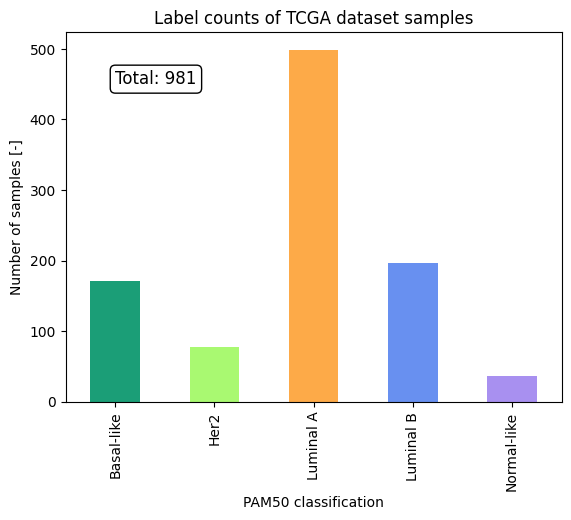

In [14]:
tcga_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of TCGA dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 450, f"Total: {tcga_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [15]:
#tcga_count_df.to_csv(f"{path}/all_processed/X_TCGA_BRCA.csv.tar.gz", compression = "gzip")
#tcga_meta_df.to_csv(f"{path}/all_processed/y_TCGA_BRCA.csv.tar.gz", compression = "gzip")

## METABRIC - NO GEO assigned

In [16]:
# metadata
metabric_meta_df = pd.read_csv(f"{path}/METABRIC/brca_metabric_clinical_data.tsv.zip", sep="\t")
metabric_meta_df.rename(columns={'Pam50 + Claudin-low subtype':'Subtype'}, inplace=True)
metabric_meta_df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


In [17]:
metabric_meta_df.shape

(2509, 39)

In [18]:
# counts
metabric_count_df = pd.read_csv(f"{path}/METABRIC/data_mrna_agilent_microarray.txt.zip", sep="\t")
metabric_count_df = preprocess_counts_no_merge(metabric_count_df, "Hugo_Symbol", "Entrez_Gene_Id")
metabric_count_df.head()

,MB-0362,MB-0346,MB-0386,MB-0574,MB-0503,MB-0641,MB-0201,MB-0218,MB-0316,MB-0189,...,MB-6122,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313
Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
1,5.607785,5.515704,5.581684,5.602209,5.443726,5.374949,5.625163,5.533212,5.359228,5.468251,...,5.302562,5.511685,5.627259,5.456827,5.455892,5.283639,5.361517,5.432268,5.620578,5.799607
2,7.653319,6.564312,8.201633,7.587296,7.545219,8.693606,8.898809,8.763382,9.100264,9.990596,...,7.850466,7.736627,9.005442,8.696260,8.796967,10.127953,11.078945,8.714076,8.333257,10.018235
9,10.628267,6.639451,10.330668,9.170203,8.658371,9.569676,5.733174,9.629111,6.176382,6.342962,...,8.431149,8.560524,8.613745,6.332610,10.297384,5.977021,6.282221,8.899801,11.060929,8.317049
10,5.639788,5.373945,5.483768,5.987228,5.468384,6.131064,5.119602,5.467175,5.522088,5.609751,...,5.349204,5.414660,5.238348,5.525921,5.231243,5.351139,5.221490,6.692538,5.817706,6.067807
12,13.582444,10.207710,11.789055,13.731758,12.564908,12.296457,10.565046,14.300028,11.986363,12.175344,...,12.409417,11.108355,13.731721,7.993557,14.169804,11.175380,13.230864,10.681164,14.169804,11.610352


In [19]:
metabric_count_df.shape

(18207, 1904)

In [20]:
metabric_meta_df = process_metadata(metabric_meta_df, "METABRIC", metabric_count_df)
metabric_meta_df.groupby("PAM50")['Sample ID'].count()

PAM50
Basal-like     199
Claudin-low    199
Her2           220
Luminal A      679
Luminal B      461
Normal-like    140
Name: Sample ID, dtype: int64

In [21]:
metabric_meta_df.shape

(1898, 3)

In [22]:
metabric_count_df = metabric_count_df[metabric_meta_df["Sample ID"].tolist()]
metabric_count_df.shape

(18207, 1898)

Text(0, 600, 'Total: 1898')

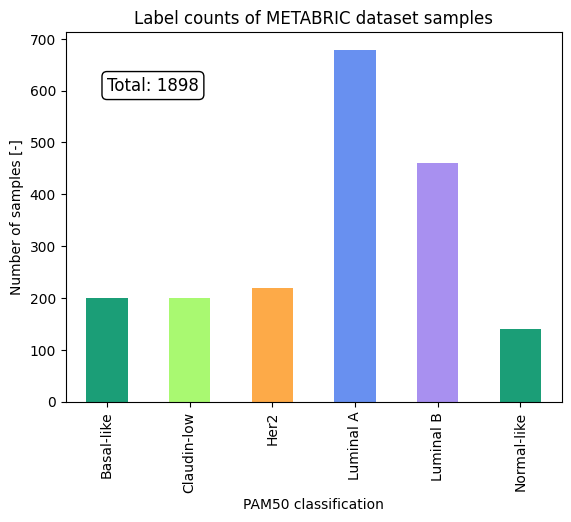

In [23]:
metabric_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of METABRIC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 600, f"Total: {metabric_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [24]:
#metabric_count_df.to_csv(f"{path}/all_processed/X_METABRIC_BRCA.csv.tar.gz", compression = "gzip")
#metabric_meta_df.to_csv(f"{path}/all_processed/y_METABRIC_BRCA.csv.tar.gz", compression = "gzip")

## CPTAC (2020)- NO GEO assigned

In [25]:
# metadata
cptac_meta_df = pd.read_csv(f"{path}/cptac_2020/brca_cptac_2020_clinical_data.tsv.zip", sep="\t")
cptac_meta_df.rename(columns={'PAM50':'Subtype'}, inplace=True)
cptac_meta_df.shape

(122, 19)

In [26]:
cptac_meta_df.head()

,Patient ID,Sample ID,Mutation Count,Age,Sex,Chromosome INstability index CIN,Ethnicity,Subtype,Tumor Stage,APOBEC Signature,CD3 TILS Counts,CD3 TILS Status,CIBERSORT Absolute Score,ER Updated Clinical Status,ERBB2 Gene Amplified,ERBB2 Proteogenomic Status,ERBB2 Updated Clinical Status,ESTIMATE Immune Score,ESTIMATE Stromal Score
0,CPT000814,CPT000814,82,NaN,NaN,2.271946,Black or African American,Basal,Stage IIA,N,not performed,not performed,0.565019,Negative,0,Negative,NaN,846.350897,-812.409581
1,CPT001846,CPT001846,72,NaN,NaN,0.826617,White,Basal,Stage III,N,not performed,not performed,0.785537,Negative,0,Negative,NaN,1425.391899,495.603750
2,X01BR001,X01BR001,71,55.0,Female,1.137609,Black or African American,Basal,Stage IIB,N,not performed,not performed,0.454490,Negative,0,Negative,Negative,475.804314,-476.863678
3,X01BR008,X01BR008,122,NaN,NaN,0.466992,NaN,Basal,NaN,N,not performed,not performed,2.064309,NaN,0,Negative,NaN,2809.591640,-77.281727
4,X01BR009,X01BR009,112,NaN,NaN,4.302139,NaN,Basal,NaN,N,not performed,not performed,1.191462,Negative,0,Negative,NaN,1664.855380,725.734350


In [27]:
# counts
cptac_count_df = pd.read_csv(f"{path}/cptac_2020/data_mrna_seq_fpkm.txt.zip", sep="\t", index_col=0)
cptac_count_df = merge_counts(cptac_count_df, df, "Hugo", "Entrez", "Affymetrix")
cptac_count_df

,CPT000814,CPT001846,X01BR001,X01BR008,X01BR009,X01BR010,X01BR015,X01BR017,X01BR018,X01BR020,...,X20BR002,X20BR005,X20BR006,X20BR007,X20BR008,X21BR001,X21BR002,X21BR010,X22BR005,X22BR006
Entrez,,,,,,,,,,,,,,,,,,,,,
1,1.9265,3.6578,0.9896,0.5535,2.8359,1.5804,1.9006,-0.8184,-0.2645,NaN,...,4.7120,NaN,NaN,NaN,NaN,2.1736,NaN,-0.3261,-1.2102,0.7403
2,5.3718,5.3253,5.4734,5.8701,6.9307,5.5849,6.5595,6.5173,6.4225,6.2846,...,7.5384,6.6644,6.1730,6.8615,7.1951,6.1540,9.0054,6.9516,6.7257,7.3029
9,0.2785,1.6788,1.5231,0.7230,1.4593,2.8746,4.3176,1.3823,1.0939,0.1901,...,0.1684,0.6074,2.4286,0.9500,1.8685,3.5939,6.3453,8.7164,4.6964,8.5108
10,NaN,NaN,-3.6575,NaN,-4.3191,3.0670,-3.6126,-2.0656,-0.8613,-4.2005,...,NaN,-0.8362,-0.6130,-2.2714,1.1305,-2.1069,4.9206,1.0347,-0.0037,0.3227
12,8.9943,4.5835,9.7278,6.0848,8.7001,5.0330,7.5016,5.2858,8.9549,0.1078,...,5.8368,6.2576,5.6763,3.4811,5.8682,6.3421,11.1222,8.5215,9.0884,9.0199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124908554,NaN,11.1726,NaN,NaN,-1.9691,NaN,NaN,NaN,NaN,2.8592,...,NaN,NaN,NaN,NaN,-2.1346,NaN,NaN,NaN,0.4405,NaN
124908555,NaN,11.1726,NaN,NaN,-1.9691,NaN,NaN,NaN,NaN,2.8592,...,NaN,NaN,NaN,NaN,-2.1346,NaN,NaN,NaN,0.4405,NaN
124908556,NaN,11.1726,NaN,NaN,-1.9691,NaN,NaN,NaN,NaN,2.8592,...,NaN,NaN,NaN,NaN,-2.1346,NaN,NaN,NaN,0.4405,NaN


In [28]:
cptac_meta_df = process_metadata(cptac_meta_df, "CPTAC", cptac_count_df)
cptac_meta_df.groupby("PAM50").count()["Sample ID"]

PAM50
Basal-like     29
Her2           14
Luminal A      57
Luminal B      17
Normal-like     5
Name: Sample ID, dtype: int64

In [29]:
cptac_meta_df.shape

(122, 3)

In [30]:
cptac_count_df = cptac_count_df[cptac_meta_df["Sample ID"].tolist()]
cptac_count_df.shape

(17385, 122)

Text(0, 50, 'Total: 122')

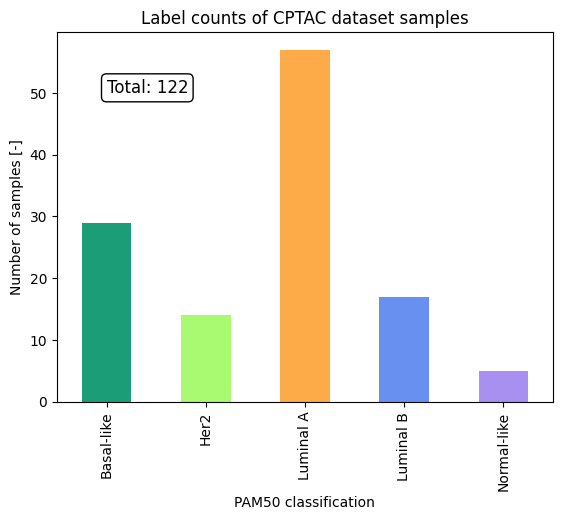

In [31]:
cptac_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of CPTAC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 50, f"Total: {cptac_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [32]:
#cptac_count_df.to_csv(f"{path}/all_processed/X_CPTAC_BRCA.csv.tar.gz", compression = "gzip")
#cptac_meta_df.to_csv(f"{path}/all_processed/y_CPTAC_BRCA.csv.tar.gz", compression = "gzip")

## SMC (2018) - (Korean cohort,  GSE113184)


In [33]:
# metadata
smc2018_meta_df = pd.read_csv(f"{path}/smc_2018/brca_smc_2018_clinical_data.tsv.zip",  sep="\t")
smc2018_meta_df.rename(columns={'PAM50 subtype':'Subtype'}, inplace=True)
smc2018_meta_df.head()

,Patient ID,Sample ID,Cancer Type Detailed,Mutation Count,Diagnosis Age,Chemotherapy,Cohort,Cytolytic Activity Score,Histology,Immunohistochemistry Subtype,Menopausal Status At Diagnosis,Mutation Burden,Oncotree Code,Subtype
0,brca_smc_2018_BB01_002,brca_smc_2018_BB01_002,Breast Invasive Ductal Carcinoma,20.0,58.91,No,IBC,11.655878,Ductal Carcinoma,ER+,Post,1.30103,IDC,LuminalB
1,brca_smc_2018_BB01_004,brca_smc_2018_BB01_004,Breast Invasive Ductal Carcinoma,6.0,46.69,No,IBC,61.077345,Ductal Carcinoma,TN,Pre,0.69897,IDC,Basal
2,brca_smc_2018_BB01_005,brca_smc_2018_BB01_005,Breast Invasive Ductal Carcinoma,35.0,50.84,No,IBC,11.329466,Ductal Carcinoma,ER+HER2+,Pre,1.54407,IDC,LuminalB
3,brca_smc_2018_BB01_006,brca_smc_2018_BB01_006,Breast Invasive Ductal Carcinoma,55.0,52.64,No,IBC,5.988873,Ductal Carcinoma,ER+,Post,1.75587,IDC,LuminalB
4,brca_smc_2018_BB01_007,brca_smc_2018_BB01_007,Breast Invasive Ductal Carcinoma,27.0,46.96,Yes,IBC,6.635089,Ductal Carcinoma,UA,Pre,1.44716,IDC,LuminalB


In [34]:
# counts
smc2018_count_df = pd.read_csv(f"{path}/smc_2018/data_mrna_seq_tpm_zscores_ref_all_samples.zip", sep="\t")
smc2018_count_df = smc2018_count_df.drop("Entrez_Gene_Id", axis=1)
smc2018_count_df = smc2018_count_df[smc2018_count_df["Hugo_Symbol"].notna()]
smc2018_count_df = smc2018_count_df.set_index("Hugo_Symbol")
smc2018_count_df = smc2018_count_df[~smc2018_count_df.index.duplicated()]
smc2018_count_df.sort_index(inplace=True)
smc2018_count_df = merge_counts(smc2018_count_df, df, "Hugo", "Entrez", "Affymetrix")
smc2018_count_df

,brca_smc_2018_BB01_002,brca_smc_2018_BB01_004,brca_smc_2018_BB01_005,brca_smc_2018_BB01_006,brca_smc_2018_BB01_007,brca_smc_2018_BB01_008,brca_smc_2018_BB01_009,brca_smc_2018_BB01_010,brca_smc_2018_BB01_011,brca_smc_2018_BB01_012,...,brca_smc_2018_BR418,brca_smc_2018_BR419,brca_smc_2018_BR414,brca_smc_2018_BR437,brca_smc_2018_BR431,brca_smc_2018_BR442,brca_smc_2018_BR457,brca_smc_2018_BR469,brca_smc_2018_BR064,brca_smc_2018_BR077
Entrez,,,,,,,,,,,,,,,,,,,,,
1,0.1424,-0.3950,0.0690,0.6187,-0.3344,-0.7266,0.4011,-0.4657,1.5346,0.4141,...,0.1653,0.2076,0.6956,1.0341,0.6036,1.1606,1.4550,0.5456,-1.9925,-1.8268
2,-0.2089,1.2484,-0.1715,0.0272,0.0794,0.0548,0.5795,0.3256,0.4089,0.3384,...,-0.1922,-0.1506,-1.1450,0.7362,0.2976,0.4027,-1.2146,0.2982,-0.5862,0.7406
9,-0.3966,-0.4969,-0.9528,0.6013,-0.7168,1.7149,0.4172,-0.1516,0.3625,-0.0949,...,0.0746,0.0284,0.9258,0.5788,-0.0572,-0.4928,-0.2963,1.0040,0.5608,0.0875
10,-0.4022,0.1755,-0.2428,0.0283,-0.8931,0.6212,-0.3341,0.4644,-0.8931,-0.7872,...,-0.2685,-0.0847,-0.1081,-0.1319,-0.5922,-0.3076,-0.3610,0.0609,-0.3746,-0.6233
12,-0.9166,-0.5486,0.2177,-0.5956,1.3113,-0.3160,-0.4763,-0.7911,1.5448,0.5339,...,1.5192,-0.2021,0.2447,1.3452,2.0195,-0.0494,-1.3149,1.0919,1.0534,0.8017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124909318,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,...,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333
124909320,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,...,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333,-12.3333
124909329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
smc2018_count_df.head()

,brca_smc_2018_BB01_002,brca_smc_2018_BB01_004,brca_smc_2018_BB01_005,brca_smc_2018_BB01_006,brca_smc_2018_BB01_007,brca_smc_2018_BB01_008,brca_smc_2018_BB01_009,brca_smc_2018_BB01_010,brca_smc_2018_BB01_011,brca_smc_2018_BB01_012,...,brca_smc_2018_BR418,brca_smc_2018_BR419,brca_smc_2018_BR414,brca_smc_2018_BR437,brca_smc_2018_BR431,brca_smc_2018_BR442,brca_smc_2018_BR457,brca_smc_2018_BR469,brca_smc_2018_BR064,brca_smc_2018_BR077
Entrez,,,,,,,,,,,,,,,,,,,,,
1,0.1424,-0.3950,0.0690,0.6187,-0.3344,-0.7266,0.4011,-0.4657,1.5346,0.4141,...,0.1653,0.2076,0.6956,1.0341,0.6036,1.1606,1.4550,0.5456,-1.9925,-1.8268
2,-0.2089,1.2484,-0.1715,0.0272,0.0794,0.0548,0.5795,0.3256,0.4089,0.3384,...,-0.1922,-0.1506,-1.1450,0.7362,0.2976,0.4027,-1.2146,0.2982,-0.5862,0.7406
9,-0.3966,-0.4969,-0.9528,0.6013,-0.7168,1.7149,0.4172,-0.1516,0.3625,-0.0949,...,0.0746,0.0284,0.9258,0.5788,-0.0572,-0.4928,-0.2963,1.0040,0.5608,0.0875
10,-0.4022,0.1755,-0.2428,0.0283,-0.8931,0.6212,-0.3341,0.4644,-0.8931,-0.7872,...,-0.2685,-0.0847,-0.1081,-0.1319,-0.5922,-0.3076,-0.3610,0.0609,-0.3746,-0.6233
12,-0.9166,-0.5486,0.2177,-0.5956,1.3113,-0.3160,-0.4763,-0.7911,1.5448,0.5339,...,1.5192,-0.2021,0.2447,1.3452,2.0195,-0.0494,-1.3149,1.0919,1.0534,0.8017


In [36]:
smc2018_meta_df = process_metadata(smc2018_meta_df, "SMC", smc2018_count_df)
smc2018_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like     36
Her2           18
Luminal A      47
Luminal B      65
Normal-like     2
Name: Sample ID, dtype: int64

In [37]:
smc2018_meta_df.shape

(168, 3)

In [38]:
smc2018_count_df = smc2018_count_df[smc2018_meta_df["Sample ID"].tolist()]
smc2018_count_df = smc2018_count_df[~smc2018_count_df.index.duplicated()]
smc2018_count_df.sort_index(inplace=True)
smc2018_count_df.shape

(17507, 168)

Text(0, 55, 'Total: 168')

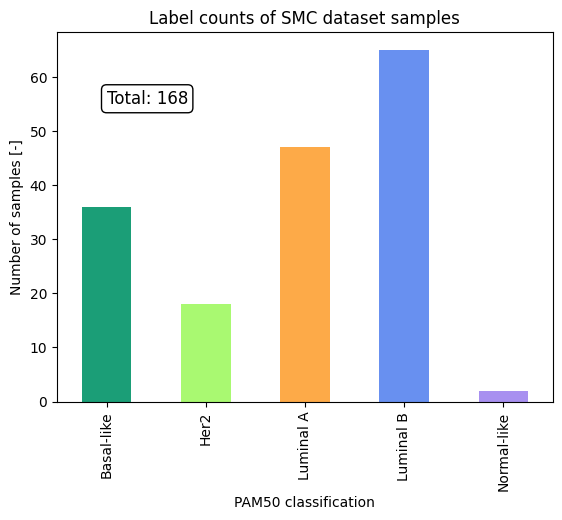

In [39]:
smc2018_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of SMC dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 55, f"Total: {smc2018_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [40]:
#smc2018_count_df.to_csv(f"{path}/all_processed/X_SMC_BRCA.csv.tar.gz", compression = "gzip")
#smc2018_meta_df.to_csv(f"{path}/all_processed/y_SMC_BRCA.csv.tar.gz", compression = "gzip")

## GSE96058 (Swedish cohort)

ClinicalTrials.gov identifier: NCT02306096

In [41]:
# metadata
geo ="GSE96058"
gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)

gse96058_d = {}
for gsm_name, gsm in gse.gsms.items():
  gse96058_d[gsm.metadata["title"][0]] = gsm.metadata["characteristics_ch1"][20][15:]

In [42]:
gse96058_meta_df = pd.DataFrame(gse96058_d.items())
gse96058_meta_df.columns = ["Sample ID", "Subtype"]

In [43]:
gse96058_meta_df.shape

(3409, 2)

Count matrix was downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96058 metadata was loaded via GEOparse package.

In [44]:
# counts
gse96058_count_df = pd.read_csv(f"{path}/GSE96058/GSE96058_gene_expression_3273_samples_and_136_replicates_transformed.csv.zip", index_col=0)
gse96058_count_df = merge_counts(gse96058_count_df, df, "Hugo", "Entrez", "Affymetrix")
gse96058_count_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F2974repl,F3006repl,F3028repl,F3057repl,F3058repl,F3085repl,F3127repl,F3135repl,F3250repl,F3265repl
Entrez,,,,,,,,,,,,,,,,,,,,,
1,0.598115,2.363673,2.647738,1.378576,2.759643,2.287331,1.404053,1.767546,3.082967,2.391895,...,0.737636,2.842583,1.777385,1.418644,2.400974,3.437225,0.693220,1.487851,0.885076,2.664302
2,6.172477,7.113514,5.641996,7.236769,7.508171,9.701680,8.041422,8.244968,6.697515,7.306434,...,6.494338,6.265418,7.319977,8.223603,6.501812,4.870941,6.377099,8.077915,7.406075,6.830662
9,1.605137,7.662760,2.849914,6.974007,4.076756,1.097102,1.981681,3.191443,1.416926,3.733380,...,3.026687,1.917900,6.127962,3.812736,4.340904,5.148111,2.103732,0.646387,1.678737,6.674637
10,-2.351626,-3.321928,-3.321928,-0.859745,-2.026123,-3.321928,-0.118744,-2.171849,-2.994729,-1.849633,...,-1.092592,-3.321928,-0.634968,-0.917910,-1.752315,-1.792567,-2.506131,-0.179804,-2.441619,-1.860363
12,10.291038,11.025054,3.998714,7.805376,4.960846,7.347768,6.770758,5.939775,5.322135,7.292353,...,6.940293,5.341759,6.708075,8.901877,3.403029,10.697190,7.901593,5.787897,2.022718,8.875006


In [45]:
gse96058_count_df.shape

(17952, 3409)

In [46]:
gse96058_count_df.isna().sum().sum()

0

In [47]:
gse96058_meta_df = process_metadata(gse96058_meta_df, "GSE96058", gse96058_count_df)
gse96058_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like      339
Her2            327
Luminal A      1657
Luminal B       729
Normal-like     221
Name: Sample ID, dtype: int64

Text(0, 1450, 'Total: 3273')

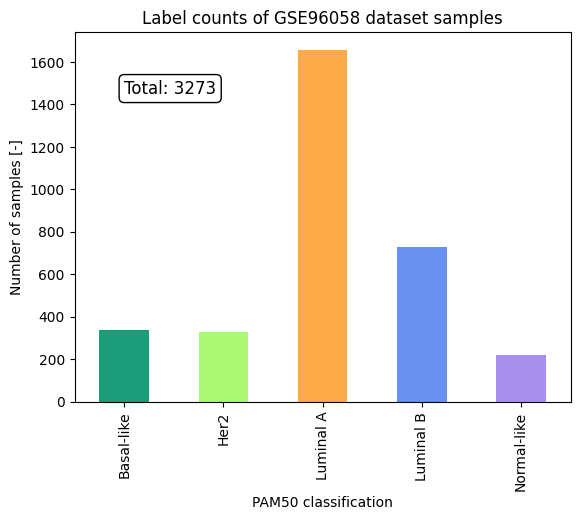

In [48]:
gse96058_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of GSE96058 dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 1450, f"Total: {gse96058_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [49]:
gse96058_count_df = gse96058_count_df[gse96058_meta_df["Sample ID"].tolist()]

In [50]:
#gse96058_count_df.to_csv(f"{path}/all_processed/X_gse96058_BRCA.csv.tar.gz", compression = "gzip")
#gse96058_meta_df.to_csv(f"{path}/all_processed/y_gse96058_BRCA.csv.tar.gz", compression = "gzip")

## GSE81538

In [51]:
# metadata
geo ="GSE81538"
gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)

gse81538_d = {}
for gsm_name, gsm in gse.gsms.items():
  gse81538_d[gsm.metadata["title"][0]] = gsm.metadata["characteristics_ch1"][37][15:]

In [52]:
gse81538_meta_df = pd.DataFrame(gse81538_d.items())
gse81538_meta_df.columns = ["Sample ID", "Subtype"]

In [53]:
gse81538_meta_df

,Sample ID,Subtype
0,T1,Basal
1,T2,Her2
2,T3,LumB
3,T4,Her2
4,T5,LumB
...,...,...
400,T401,LumA
401,T402,LumB
402,T403,Basal
403,T404,Her2


In [54]:
# counts
gse81538_count_df = pd.read_csv(f"{path}/GSE81538/GSE81538_gene_expression_405_transformed.csv.zip", index_col=0)
gse81538_count_df = gse81538_count_df[gse81538_meta_df["Sample ID"].tolist()]
gse81538_count_df = merge_counts(gse81538_count_df, df, "Hugo", "Entrez", "Affymetrix")
gse81538_count_df.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T396,T397,T398,T399,T400,T401,T402,T403,T404,T405
Entrez,,,,,,,,,,,,,,,,,,,,,
1,1.590427,0.782005,5.124489,3.537580,3.874691,2.272538,3.550594,3.136737,3.161802,3.151932,...,4.098176,3.495086,3.561725,4.623393,4.188254,2.779785,3.069689,1.135712,3.708821,3.045782
2,10.532488,4.758267,5.989012,7.436564,6.752650,6.035074,7.284499,5.581803,6.187325,7.423513,...,6.754766,6.443798,6.114044,7.120607,6.354852,7.585414,6.447292,10.521861,7.151961,6.594755
9,1.374393,2.803319,4.920610,3.636281,4.299402,0.717118,4.699293,1.742684,5.712671,2.355874,...,4.125697,3.086589,1.500062,5.322088,3.107014,6.312564,5.168021,-0.558872,6.940641,5.077390
10,-3.321928,4.428103,-1.195091,-2.128736,-2.522595,-3.321928,-1.314053,-0.390273,-1.431363,0.242293,...,-3.321928,-0.702165,-3.321928,-0.646126,-1.367481,-3.321928,-2.247083,-3.321928,-2.139465,-3.321928
12,5.823125,4.847916,7.366453,6.579003,7.722411,4.910639,7.482039,4.502454,8.200193,5.221923,...,8.584209,6.712483,7.555696,7.832318,11.689896,9.704837,6.306853,7.844896,7.046327,9.172240


In [55]:
gse81538_count_df.shape

(16252, 405)

In [56]:
gse81538_meta_df.shape

(405, 2)

In [57]:
gse81538_meta_df = process_metadata(gse81538_meta_df, "GSE81538", gse81538_count_df)
gse81538_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like      57
Her2            65
Luminal A      156
Luminal B      105
Normal-like     22
Name: Sample ID, dtype: int64

Text(0, 140, 'Total: 405')

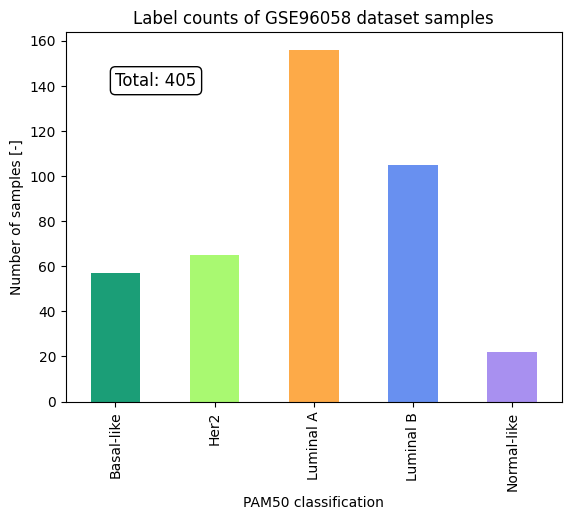

In [58]:
gse81538_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of GSE96058 dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 140, f"Total: {gse81538_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [59]:
#gse81538_count_df.to_csv(f"{path}/all_processed/X_gse81538_BRCA.csv.tar.gz", compression = "gzip")
#gse81538_meta_df.to_csv(f"{path}/all_processed/y_gse81538_BRCA.csv.tar.gz", compression = "gzip")

## NKI/TRANSBIG/UPP/UKT datasets

These datasets were loaded here by installing libraries - breastCancerNKI, breastCancerTRANSBIG, breastCancerUPP and breastCancerUNT. The data were loaded via data() and exprs() functions and saved to csv.


In [60]:
# metadata
dmeta_df = pd.read_csv(f"{path}/nki_upp_transbig_unt_labels.csv.zip", sep=";")
dmeta_df.columns = ["Sample ID", "Subtype"]
dmeta_df["Study ID"] = "NKI/TRANSBIG/UPP/UKT"
dmeta_df.tail()

,Sample ID,Subtype,Study ID
812,NKI_398,Basal,NKI/TRANSBIG/UPP/UKT
813,NKI_401,LumA,NKI/TRANSBIG/UPP/UKT
814,NKI_402,Basal,NKI/TRANSBIG/UPP/UKT
815,NKI_403,LumA,NKI/TRANSBIG/UPP/UKT
816,NKI_404,LumA,NKI/TRANSBIG/UPP/UKT


In [61]:
dmeta_df.shape

(817, 3)

#### NKI

In [63]:
# counts
nki_count_df = pd.read_csv(f"{path}/NKI/nki_count_matrix.csv.zip", index_col=0)
nki_count_df.index.name = "hgnc_symbol"
nki_count_df = merge_counts(nki_count_df, df, "Hugo", "Entrez", "Affymetrix")
nki_count_df.head()

,NKI_4,NKI_6,NKI_7,NKI_8,NKI_9,NKI_11,NKI_12,NKI_13,NKI_14,NKI_17,...,NKI_393,NKI_394,NKI_395,NKI_396,NKI_397,NKI_398,NKI_401,NKI_402,NKI_403,NKI_404
Entrez,,,,,,,,,,,,,,,,,,,,,
1,-0.050,0.125,0.426,-0.016,0.307,-0.310,-0.174,0.280,0.056,0.116,...,0.054,0.048,-0.055,-0.120,0.202,-0.092,0.054,-0.067,0.345,0.442
2,-0.384,-0.314,0.053,-0.035,-0.169,-0.116,0.530,-0.122,-0.141,0.074,...,-0.173,-0.366,-0.090,-0.486,-0.327,-0.455,-0.664,-0.173,-0.091,-0.280
9,0.087,0.491,-0.771,-0.507,-0.537,-0.136,-0.915,-0.340,0.659,-0.012,...,-0.082,-0.422,0.031,-0.471,0.771,-0.693,0.112,-0.788,0.174,-0.282
10,0.067,-0.027,-0.019,-0.129,0.098,0.001,0.100,0.086,-0.002,0.067,...,-0.087,0.056,-0.086,0.059,-0.027,-0.282,-0.112,0.103,-0.041,0.071
12,-0.533,0.695,0.089,0.093,0.166,-0.759,NaN,-0.082,-0.306,0.273,...,-0.548,0.493,0.204,-0.769,-0.378,-0.619,0.597,0.305,-0.238,0.119


In [64]:
nki_count_df.sort_index(inplace=True) 
nki_count_df.shape

(10797, 337)

In [65]:
# metadata
nki_meta = pd.DataFrame(nki_count_df.columns.tolist())
nki_meta.columns = ["Sample ID"]
nki_meta = process_metadata(nki_meta, "NKI", nki_count_df)
nki_meta.head()

,Sample ID,PAM50,Study ID
0,NKI_4,Luminal B,NKI
1,NKI_6,Luminal A,NKI
2,NKI_7,Luminal A,NKI
3,NKI_8,Basal-like,NKI
4,NKI_9,Luminal B,NKI


In [66]:
nki_count_df = nki_count_df[nki_meta["Sample ID"].tolist()]
nki_count_df.shape

(10797, 337)

In [67]:
#nki_count_df.to_csv(f"{path}/all_processed/X_NKI_BRCA.csv.tar.gz", compression = "gzip")
#nki_meta.to_csv(f"{path}/all_processed/y_NKI_BRCA.csv.tar.gz", compression = "gzip")

In [62]:
%%script false --no-raise-error
# the code below contains some preprocessing steps I used for NKI dataset in R
library(tibble)
library(dplyr)
library(breastCancerNKI)

data(nki)
t <- fData(nki)
t <- t[!is.na(t$Alternative.symbols),]
ts <- t %>% select("probe", "HUGO.gene.symbol")
data <- as.data.frame(exprs(nki))
data <- rownames_to_column(data, "ID")
final <- left_join(ts, data, by=c("probe"="ID"))
final <- final[!duplicated(final$HUGO.gene.symbol),]
final <- final[!is.na(final$HUGO.gene.symbol),]
rownames(final) <- 1:dim(final)[1]
final <- column_to_rownames(final, "HUGO.gene.symbol")
final <- final %>% select(-"probe")
#write.csv(final, "nki_count_matrix.csv", row.names = T)

#### TRANSBIG

In [68]:
# counts
transbig_count_df = pd.read_csv(f"{path}/TRANSBIG/breastCancerTransbig.csv.zip", index_col=0)
transbig_count_df.tail()

,VDXGUYU_4002,VDXGUYU_4008,VDXGUYU_4011,VDXGUYU_4014,VDXGUYU_4022,VDXGUYU_4033,VDXGUYU_4034,VDXGUYU_4036,VDXGUYU_4040,VDXGUYU_4041,...,VDXRHU_2587,VDXRHU_3642,VDXRHU_4188,VDXRHU_5223,VDXRHU_5226,VDXRHU_5228,VDXRHU_5232,VDXRHU_5235,VDXRHU_5236,VDXRHU_5240
AFFX-ThrX-5_at,5.680176,2.888221,3.464008,5.564328,5.957565,1.740601,2.093126,3.763917,4.399650,3.744013,...,3.315229,3.002246,2.775177,1.804964,3.200786,3.553865,2.859465,5.588937,3.120619,3.727378
AFFX-ThrX-M_at,1.753631,1.767325,4.875803,3.361199,2.400875,5.284490,4.893867,4.095883,5.130756,3.828155,...,3.400638,1.624498,6.247997,3.568859,5.336106,5.375497,1.858311,4.302067,5.088536,2.742265
AFFX-TrpnX-3_at,2.223181,2.013092,0.581058,2.251075,4.915962,2.600288,1.879390,1.469121,2.129731,4.025017,...,3.254034,5.201070,1.566979,2.107088,1.059342,0.929578,1.906231,4.468821,5.682201,2.349358
AFFX-TrpnX-5_at,4.013873,5.355048,4.054644,4.760490,6.120431,4.468676,3.794052,4.822143,3.711549,3.809851,...,2.985075,1.985025,2.898079,2.804893,5.234032,2.431918,4.948435,5.678535,3.685063,1.658981
AFFX-TrpnX-M_at,1.603252,2.455589,2.021403,2.365204,2.774229,2.270242,1.925874,2.291870,2.236214,1.542741,...,2.523490,1.794379,2.754495,1.552359,2.281197,3.235379,2.761732,3.143182,1.916516,1.403235


In [69]:
transbig_count_df = merge_counts(transbig_count_df, df, "Affymetrix", "Entrez", "Hugo")
transbig_count_df.shape

(13306, 198)

In [70]:
# metadata
transbig_meta = pd.DataFrame(transbig_count_df.columns.tolist())
transbig_meta.columns = ["Sample ID"]
transbig_meta = process_metadata(transbig_meta, "TRANSBIG", transbig_count_df)
transbig_meta.head()

,Sample ID,PAM50,Study ID
0,VDXGUYU_4002,Her2,TRANSBIG
1,VDXGUYU_4008,Luminal B,TRANSBIG
2,VDXGUYU_4011,Basal-like,TRANSBIG
3,VDXGUYU_4014,Luminal B,TRANSBIG
4,VDXGUYU_4022,Luminal B,TRANSBIG


In [71]:
#transbig_count_df.to_csv(f"{path}/all_processed/X_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")
#transbig_meta.to_csv(f"{path}/all_processed/y_TRANSBIG_BRCA.csv.tar.gz", compression = "gzip")

#### UPP

In [72]:
# counts
upp_count_df = pd.read_csv(f"{path}/UPP/breastCancerUpp.csv.zip", index_col=0)
upp_count_df = merge_counts(upp_count_df, df, "Affymetrix", "Entrez", "Hugo")
upp_count_df.head()

,UPP_103B41,UPP_104B91,UPP_112B55,UPP_114B68,UPP_130B92,UPP_131B79,UPP_135B40,UPP_138B34,UPP_139B03,UPP_147B19,...,UPP_73A01,UPP_74A63,UPP_75A01,UPP_86A40,UPP_87A79,UPP_88A67,UPP_90A63,UPP_94A16,UPP_99A50,UPP_9B52
Entrez,,,,,,,,,,,,,,,,,,,,,
1,6.750,7.356,7.631,7.189,7.333,7.333,7.239,7.090,6.199,6.867,...,6.429,6.541,7.295,6.435,7.079,7.326,7.582,6.557,7.136,7.174
2,9.540,9.378,9.885,8.914,9.425,9.973,9.839,9.713,9.801,9.540,...,10.111,9.388,9.524,9.093,9.957,9.582,9.719,10.155,9.832,9.666
9,6.472,10.328,9.759,9.238,10.609,8.792,8.213,10.226,8.286,6.855,...,7.230,9.933,9.714,5.753,7.415,9.183,9.903,10.199,8.741,8.873
10,4.357,7.784,3.742,6.197,4.394,3.944,4.589,6.470,4.353,5.120,...,5.299,4.934,5.106,4.332,4.775,4.413,5.444,4.775,3.694,6.050
12,10.662,10.611,8.251,9.716,10.831,10.095,9.740,10.131,9.102,6.915,...,8.038,9.877,9.275,6.962,8.772,9.729,9.280,10.699,9.938,10.605


In [73]:
upp_count_df.shape

(18642, 251)

In [74]:
# metadata
upp_meta = pd.DataFrame(upp_count_df.columns.tolist())
upp_meta.columns = ["Sample ID"]
upp_meta = process_metadata(upp_meta, "UPP", upp_count_df)
upp_meta.head()

,Sample ID,PAM50,Study ID
0,UPP_103B41,Basal-like,UPP
1,UPP_104B91,Luminal B,UPP
2,UPP_112B55,Luminal B,UPP
3,UPP_114B68,Luminal B,UPP
4,UPP_130B92,Luminal A,UPP


In [75]:
upp_count_df = upp_count_df[upp_meta["Sample ID"].tolist()]

In [76]:
#upp_count_df.to_csv(f"{path}/all_processed/X_UPP_BRCA.csv.tar.gz", compression = "gzip")
#upp_meta.to_csv(f"{path}/all_processed/y_UPP_BRCA.csv.tar.gz", compression = "gzip")

#### UNT

In [77]:
# counts
unt_count_df = pd.read_csv(f"{path}/UNT/breastCancerUNT.csv.zip", index_col=0)
unt_count_df = merge_counts(unt_count_df, df, "Affymetrix", "Entrez", "Hugo")
unt_count_df.shape

(18642, 137)

In [78]:
# metadata
unt_meta = pd.DataFrame(unt_count_df.columns.tolist())
unt_meta.columns = ["Sample ID"]
unt_meta = process_metadata(unt_meta, "UNT", unt_count_df)
unt_meta.head()

,Sample ID,PAM50,Study ID
3,OXFU_12,Luminal A,UNT
5,OXFU_1248,Luminal A,UNT
6,OXFU_126,Luminal B,UNT
7,OXFU_127,Luminal A,UNT
8,OXFU_1286,Luminal B,UNT


In [79]:
unt_count_df = unt_count_df[unt_meta["Sample ID"].tolist()]

In [80]:
unt_count_df.to_csv(f"{path}/all_processed/X_UNT_BRCA.csv.tar.gz", compression = "gzip")
unt_meta.to_csv(f"{path}/all_processed/y_UNT_BRCA.csv.tar.gz", compression = "gzip")

### Label counts total

In [81]:
# metadata
upp_unt_transbig_nki = unt_meta.append(upp_meta).append(transbig_meta).append(nki_meta)

/tmp/ipykernel_15987/2426185454.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upp_unt_transbig_nki = unt_meta.append(upp_meta).append(transbig_meta).append(nki_meta)
/tmp/ipykernel_15987/2426185454.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upp_unt_transbig_nki = unt_meta.append(upp_meta).append(transbig_meta).append(nki_meta)
/tmp/ipykernel_15987/2426185454.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  upp_unt_transbig_nki = unt_meta.append(upp_meta).append(transbig_meta).append(nki_meta)


Text(0, 280, 'Total: 817')

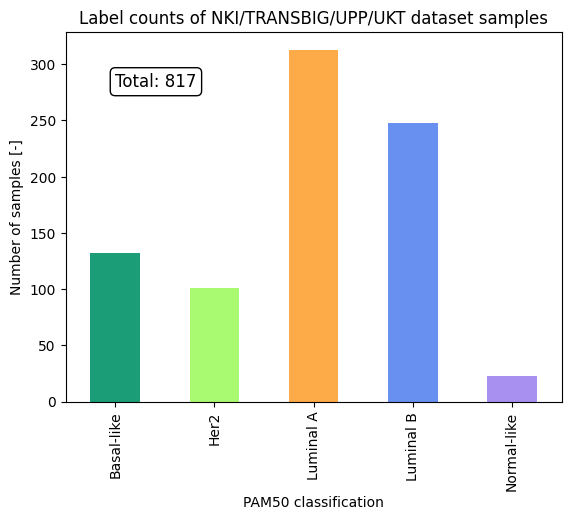

In [82]:
upp_unt_transbig_nki.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of NKI/TRANSBIG/UPP/UKT dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 280, f"Total: {dmeta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

## ROCK (GSE47561)

Metadata were taken from the paper, while data were loaded as a single file from GEO.

In [83]:
# metadata
rock_meta_df = pd.read_csv(f"{path}/ROCK/ROCK_labels.csv.zip",sep=";")
rock_meta_df = rock_meta_df[rock_meta_df["Subtype"] != "INC"]
rock_meta_df["PAM50"] = rock_meta_df["Subtype"].map(chnge_label)
rock_meta_df = rock_meta_df.drop("Subtype", axis=1)
rock_meta_df["Study ID"] = "ROCK"
rock_meta_df.head()

,Sample ID,PAM50,Study ID
0,GSM107072,Luminal A,ROCK
1,GSM107073,Luminal B,ROCK
2,GSM107075,Luminal A,ROCK
3,GSM107076,Luminal A,ROCK
4,GSM107077,Luminal B,ROCK


In [84]:
# counts
rock_count_df = pd.read_csv(f"{path}/ROCK/GSE47561_log2_RMA_renormalized_data.txt.zip", sep="\t", index_col=[0], skiprows=1)
rock_count_df = merge_counts(rock_count_df, df, "Affymetrix", "Entrez", "Hugo")
rock_count_df.shape

(13306, 1570)

In [85]:
rock_count_df = rock_count_df[rock_meta_df["Sample ID"].tolist()]
rock_count_df = rock_count_df[rock_count_df.index != ""]
rock_count_df.head()

,GSM107072,GSM107073,GSM107075,GSM107076,GSM107077,GSM107078,GSM107079,GSM107080,GSM107081,GSM107082,...,GSM65870,GSM65871,GSM65872,GSM65873,GSM65874,GSM65875,GSM65877,GSM65878,GSM65879,GSM65880
Entrez,,,,,,,,,,,,,,,,,,,,,
2,10.526080,9.157664,11.255843,11.411395,8.773838,10.567499,11.331141,11.154806,11.409200,10.304763,...,10.408770,11.587926,10.793837,10.495333,11.735920,9.775713,11.228324,10.606513,10.550262,10.911739
9,7.843712,12.430300,10.806620,10.532619,7.956286,12.151120,13.065102,4.066067,8.078012,5.677286,...,10.015693,8.396949,10.042489,11.397856,8.090137,10.817385,10.556629,4.241047,6.268133,8.006762
10,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,...,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335
12,10.901601,13.198199,8.224007,12.627136,8.772403,13.160761,9.274009,2.844708,9.417477,9.409690,...,7.866320,12.914322,10.899389,12.372636,10.819579,11.713218,12.225192,9.876904,6.916557,11.963537
13,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,...,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.221335,2.540122,2.221335


In [86]:
rock_meta_df.groupby("PAM50")["Sample ID"].count()

PAM50
Basal-like     242
Her2            69
Luminal A      688
Luminal B      377
Normal-like     92
Name: Sample ID, dtype: int64

Text(0, 630, 'Total: 1468')

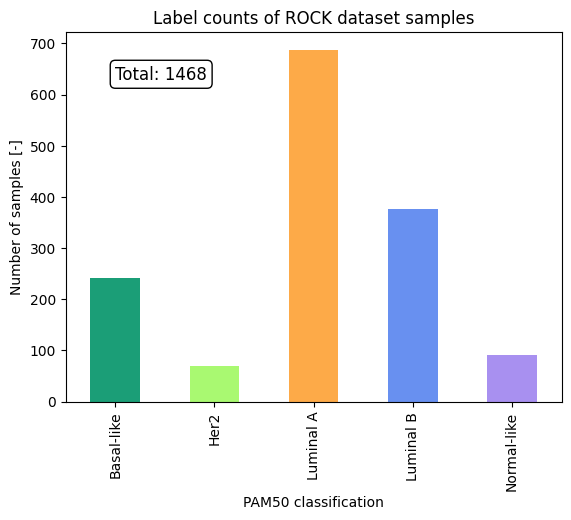

In [87]:
rock_meta_df.groupby('PAM50')["Sample ID"].count().plot.bar(color=colors, title="Label counts of ROCK dataset samples", ylabel="Number of samples [-]", xlabel = "PAM50 classification").text(0, 630, f"Total: {rock_meta_df.shape[0]}",fontsize=12, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

In [88]:
#rock_count_df.to_csv(f"{path}/all_processed/X_ROCK_BRCA.csv.tar.gz", compression = "gzip")
#rock_meta_df.to_csv(f"{path}/all_processed/y_ROCK_BRCA.csv.tar.gz", compression = "gzip")

## GEO datasets

In [89]:
# loading metadata from GEO
geo_meta = ["GSE53031", "GSE20711", "GSE78958", "GSE48390", "GSE45827", "GSE65194", "GSE25066", "GSE56493", "GSE60789", "GSE135298", "GSE59595", "GSE21653"] #"GSE81002", "GSE54275"
d = {} 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for geo in geo_meta:
  gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)
  for gsm_name, gsm in gse.gsms.items():
    d[gsm_name] = (find_column(geo), geo)
    print(geo, len(d))

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE53031 1
GSE53031 2
GSE53031 3
GSE53031 4
GSE53031 5
GSE53031 6
GSE53031 7
GSE53031 8
GSE53031 9
GSE53031 10
GSE53031 11
GSE53031 12
GSE53031 13
GSE53031 14
GSE53031 15
GSE53031 16
GSE53031 17
GSE53031 18
GSE53031 19
GSE53031 20
GSE53031 21
GSE53031 22
GSE53031 23
GSE53031 24
GSE53031 25
GSE53031 26
GSE53031 27
GSE53031 28
GSE53031 29
GSE53031 30
GSE53031 31
GSE53031 32
GSE53031 33
GSE53031 34
GSE53031 35
GSE53031 36
GSE53031 37
GSE53031 38
GSE53031 39
GSE53031 40
GSE53031 41
GSE53031 42
GSE53031 43
GSE53031 44
GSE53031 45
GSE53031 46
GSE53031 47
GSE53031 48
GSE53031 49
GSE53031 50
GSE53031 51
GSE53031 52
GSE53031 53
GSE53031 54
GSE53031 55
GSE53031 56
GSE53031 57
GSE53031 58
GSE53031 59
GSE53031 60
GSE53031 61
GSE53031 62
GSE53031 63
GSE53031 64
GSE53031 65
GSE53031 66
GSE53031 67
GSE53031 68
GSE53031 69
GSE53031 70
GSE53031 71
GSE53031 72
GSE53031 73
GSE53031 74
GSE53031 75
GSE53031 76
GSE53031 77
GSE53031 78
GSE53031 79
GSE53031 80
GSE53031 81
GSE53031 82
GSE53031 83
GSE53031 84
G

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE20711 168
GSE20711 169
GSE20711 170
GSE20711 171
GSE20711 172
GSE20711 173
GSE20711 174
GSE20711 175
GSE20711 176
GSE20711 177
GSE20711 178
GSE20711 179
GSE20711 180
GSE20711 181
GSE20711 182
GSE20711 183
GSE20711 184
GSE20711 185
GSE20711 186
GSE20711 187
GSE20711 188
GSE20711 189
GSE20711 190
GSE20711 191
GSE20711 192
GSE20711 193
GSE20711 194
GSE20711 195
GSE20711 196
GSE20711 197
GSE20711 198
GSE20711 199
GSE20711 200
GSE20711 201
GSE20711 202
GSE20711 203
GSE20711 204
GSE20711 205
GSE20711 206
GSE20711 207
GSE20711 208
GSE20711 209
GSE20711 210
GSE20711 211
GSE20711 212
GSE20711 213
GSE20711 214
GSE20711 215
GSE20711 216
GSE20711 217
GSE20711 218
GSE20711 219
GSE20711 220
GSE20711 221
GSE20711 222
GSE20711 223
GSE20711 224
GSE20711 225
GSE20711 226
GSE20711 227
GSE20711 228
GSE20711 229
GSE20711 230
GSE20711 231
GSE20711 232
GSE20711 233
GSE20711 234
GSE20711 235
GSE20711 236
GSE20711 237
GSE20711 238
GSE20711 239
GSE20711 240
GSE20711 241
GSE20711 242
GSE20711 243
GSE20711 244

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE48390 682
GSE48390 683
GSE48390 684
GSE48390 685
GSE48390 686
GSE48390 687
GSE48390 688
GSE48390 689
GSE48390 690
GSE48390 691
GSE48390 692
GSE48390 693
GSE48390 694
GSE48390 695
GSE48390 696
GSE48390 697
GSE48390 698
GSE48390 699
GSE48390 700
GSE48390 701
GSE48390 702
GSE48390 703
GSE48390 704
GSE48390 705
GSE48390 706
GSE48390 707
GSE48390 708
GSE48390 709
GSE48390 710
GSE48390 711
GSE48390 712
GSE48390 713
GSE48390 714
GSE48390 715
GSE48390 716
GSE48390 717
GSE48390 718
GSE48390 719
GSE48390 720
GSE48390 721
GSE48390 722
GSE48390 723
GSE48390 724
GSE48390 725
GSE48390 726
GSE48390 727
GSE48390 728
GSE48390 729
GSE48390 730
GSE48390 731
GSE48390 732
GSE48390 733
GSE48390 734
GSE48390 735
GSE48390 736
GSE48390 737
GSE48390 738
GSE48390 739
GSE48390 740
GSE48390 741
GSE48390 742
GSE48390 743
GSE48390 744
GSE48390 745
GSE48390 746
GSE48390 747
GSE48390 748
GSE48390 749
GSE48390 750
GSE48390 751
GSE48390 752
GSE48390 753
GSE48390 754
GSE48390 755
GSE48390 756
GSE48390 757
GSE48390 758

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE45827 763
GSE45827 764
GSE45827 765
GSE45827 766
GSE45827 767
GSE45827 768
GSE45827 769
GSE45827 770
GSE45827 771
GSE45827 772
GSE45827 773
GSE45827 774
GSE45827 775
GSE45827 776
GSE45827 777
GSE45827 778
GSE45827 779
GSE45827 780
GSE45827 781
GSE45827 782
GSE45827 783
GSE45827 784
GSE45827 785
GSE45827 786
GSE45827 787
GSE45827 788
GSE45827 789
GSE45827 790
GSE45827 791
GSE45827 792
GSE45827 793
GSE45827 794
GSE45827 795
GSE45827 796
GSE45827 797
GSE45827 798
GSE45827 799
GSE45827 800
GSE45827 801
GSE45827 802
GSE45827 803
GSE45827 804
GSE45827 805
GSE45827 806
GSE45827 807
GSE45827 808
GSE45827 809
GSE45827 810
GSE45827 811
GSE45827 812
GSE45827 813
GSE45827 814
GSE45827 815
GSE45827 816
GSE45827 817
GSE45827 818
GSE45827 819
GSE45827 820
GSE45827 821
GSE45827 822
GSE45827 823
GSE45827 824
GSE45827 825
GSE45827 826
GSE45827 827
GSE45827 828
GSE45827 829
GSE45827 830
GSE45827 831
GSE45827 832
GSE45827 833
GSE45827 834
GSE45827 835
GSE45827 836
GSE45827 837
GSE45827 838
GSE45827 839

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE65194 918
GSE65194 919
GSE65194 920
GSE65194 921
GSE65194 922
GSE65194 923
GSE65194 924
GSE65194 925
GSE65194 926
GSE65194 927
GSE65194 928
GSE65194 929
GSE65194 930
GSE65194 931
GSE65194 932
GSE65194 933
GSE65194 934
GSE65194 935
GSE65194 936
GSE65194 937
GSE65194 938
GSE65194 939
GSE65194 940
GSE65194 941
GSE65194 942
GSE65194 943
GSE65194 944
GSE65194 945
GSE65194 946
GSE65194 947
GSE65194 948
GSE65194 949
GSE65194 950
GSE65194 951
GSE65194 952
GSE65194 953
GSE65194 954
GSE65194 955
GSE65194 956
GSE65194 957
GSE65194 958
GSE65194 959
GSE65194 960
GSE65194 961
GSE65194 962
GSE65194 963
GSE65194 964
GSE65194 965
GSE65194 966
GSE65194 967
GSE65194 968
GSE65194 969
GSE65194 970
GSE65194 971
GSE65194 972
GSE65194 973
GSE65194 974
GSE65194 975
GSE65194 976
GSE65194 977
GSE65194 978
GSE65194 979
GSE65194 980
GSE65194 981
GSE65194 982
GSE65194 983
GSE65194 984
GSE65194 985
GSE65194 986
GSE65194 987
GSE65194 988
GSE65194 989
GSE65194 990
GSE65194 991
GSE65194 992
GSE65194 993
GSE65194 994

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE21653 2277
GSE21653 2278
GSE21653 2279
GSE21653 2280
GSE21653 2281
GSE21653 2282
GSE21653 2283
GSE21653 2284
GSE21653 2285
GSE21653 2286
GSE21653 2287
GSE21653 2288
GSE21653 2289
GSE21653 2290
GSE21653 2291
GSE21653 2292
GSE21653 2293
GSE21653 2294
GSE21653 2295
GSE21653 2296
GSE21653 2297
GSE21653 2298
GSE21653 2299
GSE21653 2300
GSE21653 2301
GSE21653 2302
GSE21653 2303
GSE21653 2304
GSE21653 2305
GSE21653 2306
GSE21653 2307
GSE21653 2308
GSE21653 2309
GSE21653 2310
GSE21653 2311
GSE21653 2312
GSE21653 2313
GSE21653 2314
GSE21653 2315
GSE21653 2316
GSE21653 2317
GSE21653 2318
GSE21653 2319
GSE21653 2320
GSE21653 2321
GSE21653 2322
GSE21653 2323
GSE21653 2324
GSE21653 2325
GSE21653 2326
GSE21653 2327
GSE21653 2328
GSE21653 2329
GSE21653 2330
GSE21653 2331
GSE21653 2332
GSE21653 2333
GSE21653 2334
GSE21653 2335
GSE21653 2336
GSE21653 2337
GSE21653 2338
GSE21653 2339
GSE21653 2340
GSE21653 2341
GSE21653 2342
GSE21653 2343
GSE21653 2344
GSE21653 2345
GSE21653 2346
GSE21653 2347
GSE216

In [90]:
# metadata
meta_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
#meta_df = meta_df.append(GSE10893_meta)
meta_df.columns = ["Sample ID", "Subtype", "Dataset"]
meta_df["PAM50"] = meta_df.apply(edit_subtype, axis=1)
meta_df.groupby("PAM50")["Sample ID"].count()

meta_df = meta_df[meta_df['PAM50'].notna()]
meta_df = meta_df.drop("Subtype", axis=1)
meta_df.shape 

(2320, 3)

In [91]:
meta_df["Dataset"].unique()

array(['GSE53031', 'GSE20711', 'GSE78958', 'GSE48390', 'GSE45827',
       'GSE65194', 'GSE25066', 'GSE56493', 'GSE60789', 'GSE135298',
       'GSE59595', 'GSE21653'], dtype=object)

In [94]:
#%%script false --no-raise-error
# loading counts from GEO
geo_meta = ["GSE53031", "GSE20711", "GSE78958", "GSE48390", "GSE45827", "GSE65194", "GSE25066", "GSE56493", "GSE60789", "GSE135298", "GSE59595", "GSE21653"] # "GSE81002", "GSE54275"


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

final_metadata_df = pd.DataFrame(columns=meta_df.columns)

for geo in geo_meta:
  c_df = pd.DataFrame()
  gse = GEOparse.get_GEO(geo=geo, destdir='./', silent=True)
  for gsm_name, gsm in gse.gsms.items():
     #writing table
    if geo == "GSE135298":
      continue
    cdf = gsm.table
    if cdf.empty:
      continue
    if geo == "GSE54275":
       if cdf.shape[0] == 22171:
         continue
    if geo == "GSE59595":
      cdf = cdf.drop("Detection_Pval", axis=1)
      if cdf.shape[0] == 1145:
        continue
    cdf.columns = ["index", f"{gsm_name}"]
    cdf = cdf.set_index("index")
    c_df = c_df.append(cdf.T)
  meta_geo_df = meta_df[meta_df["Dataset"] == geo]
  meta_geo_df = meta_geo_df[meta_geo_df["Sample ID"].isin(c_df.index.tolist())]
  final_metadata_df = final_metadata_df.append(meta_geo_df)
  c_df = c_df.T
  c_df = c_df[meta_geo_df["Sample ID"].tolist()]
  #c_df.to_csv(f"{path}/GEO_preprocessed/{geo}_preprocessed.csv.tar.gz", compression="gzip")
  print(geo, "Null - ", c_df.isna().sum().sum(), "Shape - ", c_df.T.shape)

/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE53031 Null -  0 Shape -  (167, 49386)


/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE20711 Null -  0 Shape -  (88, 54675)
GSE78958 Null -  0 Shape -  (424, 22277)


/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE48390 Null -  0 Shape -  (74, 54674)


/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE45827 Null -  0 Shape -  (130, 29873)


/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE65194 Null -  0 Shape -  (98, 54673)
GSE25066 Null -  0 Shape -  (508, 22283)
GSE56493 Null -  0 Shape -  (120, 52378)
GSE60789 Null -  0 Shape -  (55, 45538)
GSE135298 Null -  0.0 Shape -  (0, 0)
GSE59595 Null -  0 Shape -  (133, 48802)


/mnt/foibe3/Users/simonova/conda/envs/jup_env/lib/python3.10/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


GSE21653 Null -  0 Shape -  (242, 54613)


In [95]:
final_metadata_df.columns = ["Sample ID",	"Study ID",	"PAM50"]

In [96]:
gse = GEOparse.get_GEO(geo="GSE135298", destdir='./', silent=True)
dd = {}

for gsm_name, gsm in gse.gsms.items():
 dd[gsm.metadata["title"][0]] = (find_column("GSE135298"), "GSE135298")

GSE135298_meta_df = pd.DataFrame.from_dict(dd, orient='index').reset_index()
GSE135298_meta_df.columns = ["Sample ID", "Subtype", "Study ID"]
GSE135298_meta_df["PAM50"] = GSE135298_meta_df.apply(edit_subtype, axis=1)
GSE135298_meta_df = GSE135298_meta_df[meta_df['PAM50'].notna()]
GSE135298_meta_df = GSE135298_meta_df.drop("Subtype", axis=1)
final_metadata_df = final_metadata_df.append(GSE135298_meta_df)
final_metadata_df.shape 

/tmp/ipykernel_15987/1015647068.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  GSE135298_meta_df = GSE135298_meta_df[meta_df['PAM50'].notna()]


(2132, 3)

In [97]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135298/suppl/GSE135298_OSLO2_EMIT0_RNA-seq.txt.gz
GSE135298_counts = pd.read_csv(f"{path}/GSE135298_OSLO2/GSE135298_OSLO2_EMIT0_RNA-seq.txt.gz", compression="gzip", sep="\t", index_col=0)
GSE135298_meta_df = GSE135298_meta_df[GSE135298_meta_df["Sample ID"].isin(GSE135298_counts.columns.tolist())]
GSE135298_counts = GSE135298_counts[GSE135298_meta_df["Sample ID"].tolist()]
GSE135298_counts.head()
#GSE135298_counts.to_csv(f"{path}/GEO_preprocessed/GSE135298_preprocessed.csv.tar.gz", index=True, compression="gzip")

## Generation of final metadata and count tables

### Final metadata

Below I will check consistency of column names.

In [98]:
# loading metadata
final_metadata_df = final_metadata_df[['Sample ID', 'PAM50', 'Study ID']]

In [99]:
print("TCGA - ", tcga_meta_df.columns.tolist())
print("METABRIC - ", metabric_meta_df.columns.tolist())
print("CPTAC - ", cptac_meta_df.columns.tolist())
print("SMC 2018 - ", smc2018_meta_df.columns.tolist())
print("GSE96058 - ", gse96058_meta_df.columns.tolist())
print("GSE81538 - ", gse81538_meta_df.columns.tolist())
print("NKI", nki_meta.columns.tolist())
print("TRASBIG", transbig_meta.columns.tolist())
print("UPP", upp_meta.columns.tolist())
print("UPT", unt_meta.columns.tolist())
print("ROCK", rock_meta_df.columns.tolist())
print("GEO", final_metadata_df.columns.tolist())

TCGA -  ['Sample ID', 'PAM50', 'Study ID']
METABRIC -  ['Sample ID', 'PAM50', 'Study ID']
CPTAC -  ['Sample ID', 'PAM50', 'Study ID']
SMC 2018 -  ['Sample ID', 'PAM50', 'Study ID']
GSE96058 -  ['Sample ID', 'PAM50', 'Study ID']
GSE81538 -  ['Sample ID', 'PAM50', 'Study ID']
NKI ['Sample ID', 'PAM50', 'Study ID']
TRASBIG ['Sample ID', 'PAM50', 'Study ID']
UPP ['Sample ID', 'PAM50', 'Study ID']
UPT ['Sample ID', 'PAM50', 'Study ID']
ROCK ['Sample ID', 'PAM50', 'Study ID']
GEO ['Sample ID', 'PAM50', 'Study ID']


In [100]:
concat_list = [tcga_meta_df, metabric_meta_df, cptac_meta_df, smc2018_meta_df, gse96058_meta_df, gse81538_meta_df, upp_meta, transbig_meta, nki_meta, unt_meta, rock_meta_df, final_metadata_df]

final_meta_df = pd.concat(concat_list)
final_meta_df.shape

(11264, 3)

In [101]:
final_meta_df.isna().sum()

Sample ID    0
PAM50        0
Study ID     0
dtype: int64

In [102]:
#final_meta_df.to_csv(f"{path}/metadata_breast_combined.csv", index=False)

### Final count matrix

Below I will check the consistency of row names in different datasets and their shapes to ensure that there is no empty dataframes.

In [103]:
print("TCGA - ", tcga_count_df.axes[0].tolist()[:5])
print("METABRIC - ", metabric_count_df.axes[0].tolist()[:5])
print("CPTAC - ", cptac_count_df.axes[0].tolist()[:5])
print("SMC 2018 - ", smc2018_count_df.axes[0].tolist()[:5])
print("GSE96058 - ", gse96058_count_df.axes[0].tolist()[:5])
print("GSE81538 - ", gse81538_count_df.axes[0].tolist()[:5])
print("NKI", nki_count_df.axes[0].tolist()[:5])
print("TRANSBIG", transbig_count_df.axes[0].tolist()[:5])
print("UPP", upp_count_df.axes[0].tolist()[:5])
print("UNT", unt_count_df.axes[0].tolist()[:5])
print("ROCK - ", rock_count_df.axes[0].tolist()[:5])

TCGA -  [1, 2, 9, 10, 12]
METABRIC -  [1, 2, 9, 10, 12]
CPTAC -  [1, 2, 9, 10, 12]
SMC 2018 -  [1, 2, 9, 10, 12]
GSE96058 -  [1, 2, 9, 10, 12]
GSE81538 -  [1, 2, 9, 10, 12]
NKI [1, 2, 9, 10, 12]
TRANSBIG [2, 9, 10, 12, 13]
UPP [1, 2, 9, 10, 12]
UNT [1, 2, 9, 10, 12]
ROCK -  [2, 9, 10, 12, 13]


In [104]:
print("TCGA - ", tcga_count_df.shape)
print("METABRIC - ", metabric_count_df.shape)
print("CPTAC - ", cptac_count_df.shape)
print("SMC 2018 - ", smc2018_count_df.shape)
print("GSE96058 - ", gse96058_count_df.shape)
print("GSE81538 - ", gse81538_count_df.shape)
print("NKI", nki_count_df.shape)
print("TRANSBIG", transbig_count_df.shape)
print("UPP", upp_count_df.shape)
print("UNT", unt_count_df.shape)
print("ROCK - ", rock_count_df.shape)

TCGA -  (20531, 981)
METABRIC -  (18207, 1898)
CPTAC -  (17385, 122)
SMC 2018 -  (17507, 168)
GSE96058 -  (17952, 3273)
GSE81538 -  (16252, 405)
NKI (10797, 337)
TRANSBIG (13306, 198)
UPP (18642, 190)
UNT (18642, 92)
ROCK -  (13306, 1468)


In [109]:
dfs = [gse96058_count_df, metabric_count_df, cptac_count_df, smc2018_count_df, rock_count_df, gse81538_count_df, upp_count_df, tcga_count_df, transbig_count_df, nki_count_df, unt_count_df]

counts_breast_combined = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="left"), dfs)
counts_breast_combined.shape

(17974, 9132)

In [ ]:
counts_breast_combined.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,KIU_316C64,KIU_36C17,KIU_42C67,KIU_52A90,KIU_5B97,KIU_65A68,KIU_74A63,KIU_86A40,KIU_88A67,KIU_89A64
1,0.598115,2.363673,2.647738,1.378576,2.759643,2.287331,1.404053,1.767546,3.082967,2.391895,...,-0.110640,0.112279,-0.085707,-0.212075,0.315729,0.351331,-0.522164,-0.357278,0.988975,-0.308834
2,6.172477,7.113514,5.641996,7.236769,7.508171,9.701680,8.041422,8.244968,6.697515,7.306434,...,0.534618,0.160479,-0.060345,0.536004,-0.531007,0.170196,-0.434163,-1.148968,-0.192474,-0.049900
9,1.605137,7.662760,2.849914,6.974007,4.076756,1.097102,1.981681,3.191443,1.416926,3.733380,...,-2.299569,-2.098017,1.983745,0.699055,-0.418914,-0.061206,1.469971,-4.280300,-0.026211,-2.981391
10,-2.351626,-3.321928,-3.321928,-0.859745,-2.026123,-3.321928,-0.118744,-2.171849,-2.994729,-1.849633,...,0.068940,-0.086763,0.179285,-0.173416,0.059793,0.453503,-0.071969,-0.120971,-0.113299,-0.243909
12,10.291038,11.025054,3.998714,7.805376,4.960846,7.347768,6.770758,5.939775,5.322135,7.292353,...,-0.200761,1.387728,0.613261,-1.240004,-0.759739,-0.882415,0.028298,-3.473975,-0.250373,-2.653205


### Conversion ENTREZ (for GEO datasets)

In [110]:
df = get_ensembl_mappings()
df.shape

(42043, 3)

In [111]:
p = "~/ENTREZ_converters"
illumina_probes_V4 = pd.read_csv(f"{p}/humanht-12_v4_0_r2_15002873_b.txt.zip", compression="zip", sep="\t", skiprows=8)
illumina_probes_V4 = edit_conversion_dataset(illumina_probes_V4,["ILMN_Gene", "Entrez_Gene_ID", "Probe_Id"], "Entrez_Gene_ID")
illumina_probes_V4 = illumina_probes_V4[~illumina_probes_V4.index.duplicated(keep='first')]

illumina_probes_V3 = pd.read_csv(f"{p}/humanht-12_v3_0_r3_11283641_a_txt.zip", compression="zip", sep="\t", skiprows=8)
illumina_probes_V3 = edit_conversion_dataset(illumina_probes_V3,["ILMN_Gene", "Entrez_Gene_ID", "Probe_Id"], "Entrez_Gene_ID")
illumina_probes_V3 = illumina_probes_V3[~illumina_probes_V3.index.duplicated(keep='first')]

In [112]:
# Agilent probe IDs for conversion to ENTREZ (Agilent-028004 SurePrint G3 Human GE 8x60K Microarray)
agilent_probes = pd.read_csv(f"{p}/GPL14550-9757.txt.zip", skiprows=17, sep="\t", compression="zip")
agilent_probes = edit_conversion_dataset(agilent_probes, ["ID", "GENE", "GENE_SYMBOL"], "GENE")
agilent_probes = agilent_probes[~agilent_probes.index.duplicated(keep='first')]

In [113]:
## Afymetrix probe IDs for conversion to ENTREZ (Affymetrix Human Genome U219 Array)
aff_array = pd.read_csv(f"{p}/GPL13667-15572.txt.zip", sep="\t", skiprows=43, compression="zip")
aff_array = edit_conversion_dataset(aff_array, ["ID", "Entrez Gene", "Gene Symbol"], "Entrez Gene")
aff_array = aff_array[aff_array["Entrez Gene"] != "---"]
aff_array = aff_array.drop_duplicates(subset="Entrez Gene", keep="last")
aff_array = aff_array[~aff_array["Entrez Gene"].str.contains("///")]
aff_array = aff_array[~aff_array.index.duplicated(keep='first')]
aff_array.shape

/tmp/ipykernel_15987/1133762424.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  aff_array = pd.read_csv(f"{p}/GPL13667-15572.txt.zip", sep="\t", skiprows=43, compression="zip")


(19040, 3)

In [114]:
## TGI probe IDs for conversion to ENTREZ ### GSE56493 (Rosetta/Merck Human RSTA Custom Affymetrix 2.0 microarray)
tgi_probes = pd.read_csv(f"{p}/tgi.txt", sep="\t", skiprows=11)
tgi_probes = edit_conversion_dataset(tgi_probes, ["ID", "EntrezGeneID", "GeneSymbol"], "EntrezGeneID")

In [115]:
count = 0
dff = pd.DataFrame()

for f in os.listdir(f"{path}/GEO_preprocessed"):
  if f.endswith(".tar.gz"):
    count += 1
    geo_name = f.split("_")[0]
    tdf = pd.read_csv(f"{path}/GEO_preprocessed/{f}", index_col=0, compression="gzip")
    tdf = tdf[~tdf.index.duplicated(keep='first')]
    print(geo_name)
    print("Input shape -", tdf.shape)
    if geo_name in ["GSE78958", "GSE25066", "GSE21653", "GSE48390", "GSE20711", "GSE65194", "GSE45827"]: #"GSE81002", "GSE22133", "GSE54275"
      dff = merge_counts(tdf, df, "Affymetrix", "Entrez", "Hugo")
    elif geo_name == "GSE60789":
      dff = merge_counts(tdf, illumina_probes_V4, "Probe_Id", "Entrez_Gene_ID", "ILMN_Gene") #Illumina solved
    elif geo_name == "GSE59595":
      dff.index = dff.index.astype("object")
      dff = merge_counts(tdf, illumina_probes_V3, "Probe_Id", "Entrez_Gene_ID", "ILMN_Gene") #Illumina solved
    elif geo_name == "GSE58215": # Agilent 	solved
      dff = merge_counts(tdf, agilent_probes, "ID", "GENE", "GENE_SYMBOL")
    #elif geo_name == "GSE115577":  # Entrez ID solved
    #  continue
    elif geo_name == "GSE135298": # Gene name solved
      dff = merge_counts(tdf, df, "Hugo", "Entrez", "Affymetrix")
    elif geo_name == "GSE56493":
      dff = merge_counts(tdf, tgi_probes, "ID", "EntrezGeneID", "GeneSymbol")
    elif geo_name == "GSE53031":
      dff = merge_counts(tdf, aff_array, "ID", "Entrez Gene", "Gene Symbol")
    dff = dff[~dff.index.duplicated()]
    dff.index.name = "Entrez"
    dff.index = dff.index.astype(int)
    counts_breast_combined = pd.merge(counts_breast_combined, dff, left_index=True, right_index=True, how="left")
    #print(dff)
    #dff.to_csv(f"{path}/all_processed/X_{geo_name}.csv.tar.gz", compression="gzip")

GSE65194
Input shape - (54673, 98)
GSE20711
Input shape - (54675, 88)
GSE59595
Input shape - (48802, 133)
GSE53031
Input shape - (49386, 167)
GSE60789
Input shape - (45538, 55)
GSE48390
Input shape - (54674, 74)
GSE25066
Input shape - (22283, 508)
GSE135298
Input shape - (19102, 93)
GSE56493
Input shape - (52378, 120)
GSE45827
Input shape - (29873, 130)
GSE21653
Input shape - (54613, 242)
GSE78958
Input shape - (22277, 424)


In [116]:
final_meta_df = final_meta_df[final_meta_df["Sample ID"].isin(counts_breast_combined.columns)]
counts_breast_combined = counts_breast_combined[final_meta_df["Sample ID"].tolist()]

In [117]:
counts_breast_combined.shape

(17974, 11264)

In [118]:
counts_breast_combined.head()

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,GE0089123,GE0089194,GE0089195,GE0089196,GE0089197,GE0089198,GE0089201,GE0089203,GE0089204,GE0089207
1,0.4344,0.6644,1.3806,0.3957,0.8186,0.4756,1.0114,-1.2713,0.0320,0.4073,...,4.427257,4.547933,4.083582,4.464378,4.001056,2.689814,5.519384,4.219977,4.609787,4.437998
2,-0.9636,-0.5790,-0.3558,-0.0460,-0.2392,0.1239,-1.8280,1.4813,1.0711,0.4746,...,5.874194,5.167315,7.468600,4.748633,7.337658,3.985797,4.497112,6.208392,5.863453,5.321379
9,1.2045,-0.1725,0.2166,0.1931,-0.9395,-0.0174,0.0562,-1.3572,0.4348,0.8439,...,8.632486,2.602124,0.857546,6.845860,6.063666,1.874870,2.041522,4.287545,4.990898,7.181328
10,0.4247,2.1151,-1.1072,0.3018,-1.1322,0.5353,-0.3519,-0.9300,0.2292,0.2548,...,1.769323,0.091698,0.030946,1.482156,0.256235,0.306804,0.035544,0.347548,1.394015,0.000000
12,0.3958,-2.8225,0.0803,0.2354,0.0608,0.3638,-1.5796,-0.7507,1.3426,0.8384,...,9.258610,11.472248,6.781542,8.058269,8.861155,5.336326,11.221003,8.328288,4.927424,11.146092


In [ ]:
counts_breast_combined = counts_breast_combined.fillna(0)

#final_meta_df.to_csv(f"{path}/Breast_cancer/metadata_breast_combined.csv.gz", index=False, compression="gzip")
#counts_breast_combined.to_csv(f"{path}/Breast_cancer/counts_breast_combined_no_geo.csv.tar.gz", compression="gzip", index=True)

## Final visualization of breast cancer labels

/tmp/ipykernel_2975/3027205124.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(i)) for i in ax.get_yticks()], fontsize=16)


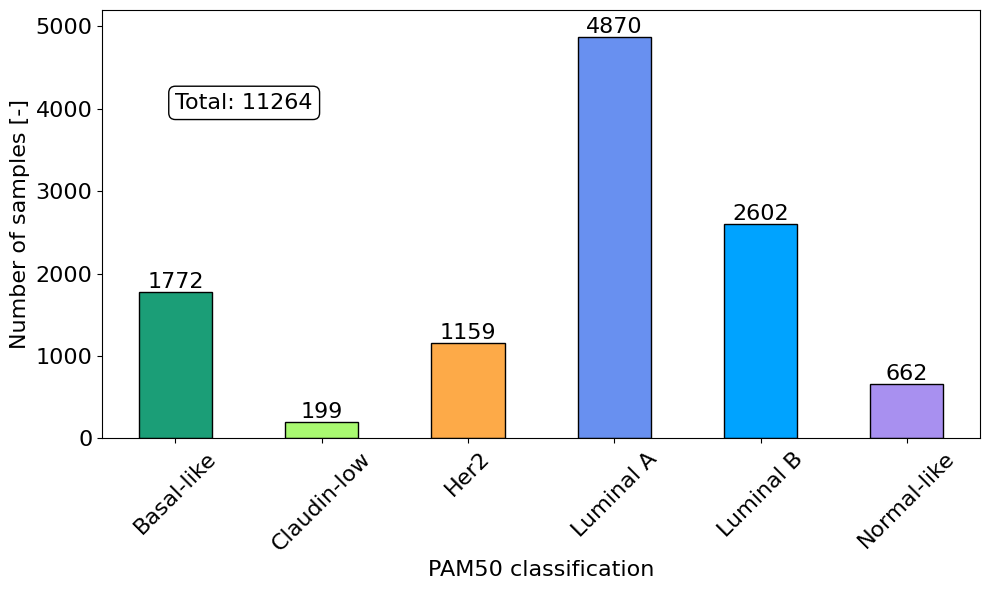

In [ ]:
colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0', "#00A3FF", '#A890F0']

frequencies = final_meta_df.groupby('PAM50')["Sample ID"].count().tolist()
freq_series = pd.Series(frequencies)
x_labels = final_meta_df.groupby('PAM50')["Sample ID"].count().index.tolist()

plt.figure(figsize=(10, 6))
ax = freq_series.plot(kind="bar", color=colors, edgecolor = "black")
#ax.set_title("Label counts of merged dataset samples")
ax.set_xlabel("PAM50 classification", fontsize=16)
ax.set_ylim(0, 5200)
ax.set_ylabel("Number of samples [-]", fontsize=16)
ax.set_xticklabels(x_labels, fontsize=16, rotation=45)
ax.set_yticklabels([str(int(i)) for i in ax.get_yticks()], fontsize=16)

rects = ax.patches

for rect, label in zip(rects, x_labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom", fontsize=16,
    )
ax.text(0, 4000, f"Total: {final_meta_df.shape[0]}",fontsize=16, bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.tight_layout()
plt.savefig(f"{path}/img/breast_labels.pdf", format="pdf")
plt.show()

## Data heterogeniety - PCA (genes)

In [ ]:
final_meta_df[final_meta_df['PAM50'].isna()]

,Sample ID,PAM50,Study ID


In [ ]:
merged_df = counts_breast_combined
merged_df = merged_df.fillna(0)
merged_df.shape

(17974, 11264)

In [ ]:
merged_df.isna().sum().sum()

0

In [ ]:
merged_df.head()

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,...,GE0089123,GE0089194,GE0089195,GE0089196,GE0089197,GE0089198,GE0089201,GE0089203,GE0089204,GE0089207
1,0.4344,0.6644,1.3806,0.3957,0.8186,0.4756,1.0114,-1.2713,0.0320,0.4073,...,4.427257,4.547933,4.083582,4.464378,4.001056,2.689814,5.519384,4.219977,4.609787,4.437998
2,-0.9636,-0.5790,-0.3558,-0.0460,-0.2392,0.1239,-1.8280,1.4813,1.0711,0.4746,...,5.874194,5.167315,7.468600,4.748633,7.337658,3.985797,4.497112,6.208392,5.863453,5.321379
9,1.2045,-0.1725,0.2166,0.1931,-0.9395,-0.0174,0.0562,-1.3572,0.4348,0.8439,...,8.632486,2.602124,0.857546,6.845860,6.063666,1.874870,2.041522,4.287545,4.990898,7.181328
10,0.4247,2.1151,-1.1072,0.3018,-1.1322,0.5353,-0.3519,-0.9300,0.2292,0.2548,...,1.769323,0.091698,0.030946,1.482156,0.256235,0.306804,0.035544,0.347548,1.394015,0.000000
12,0.3958,-2.8225,0.0803,0.2354,0.0608,0.3638,-1.5796,-0.7507,1.3426,0.8384,...,9.258610,11.472248,6.781542,8.058269,8.861155,5.336326,11.221003,8.328288,4.927424,11.146092


In [ ]:
final_meta_df.PAM50 = final_meta_df.PAM50.astype('category')
final_meta_df["Study ID"] = final_meta_df["Study ID"].astype('category')
final_meta_df.shape

(11264, 3)

In [ ]:
final_meta_df.columns = ["Sample ID", "Label", "Dataset"]
final_meta_df["Platform"] = final_meta_df["Dataset"].map(d_ilmn)
final_meta_df["Normalization"] = final_meta_df["Dataset"].map(d_norm)
final_meta_df.head()

,Sample ID,Label,Dataset,Platform,Normalization
0,TCGA-3C-AAAU-01,Luminal A,TCGA,RNA sequencing,RSEM
1,TCGA-3C-AALI-01,Her2,TCGA,RNA sequencing,RSEM
2,TCGA-3C-AALJ-01,Luminal B,TCGA,RNA sequencing,RSEM
3,TCGA-3C-AALK-01,Luminal A,TCGA,RNA sequencing,RSEM
4,TCGA-4H-AAAK-01,Luminal A,TCGA,RNA sequencing,RSEM


In [ ]:
comp, labels = scale_pca(merged_df.T)

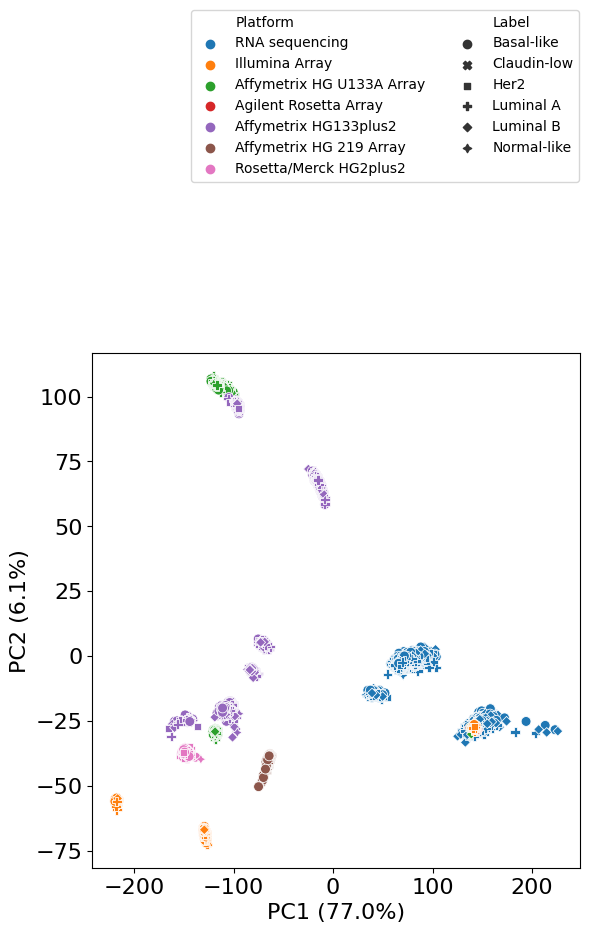

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_meta_df["Sample ID"]
c_df = pd.merge(components_df, final_meta_df, left_index=True, right_on="Sample ID", how="left")

sns.scatterplot(x="PC1", y="PC2", s=50, hue="Platform", style="Label", data=c_df)
plt.xlabel("PC1 (77.0%)", fontsize=16)
plt.ylabel("PC2 (6.1%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.legend(prop={'size': 10}, bbox_to_anchor=(0.1, 0.99, 1, 1.02), loc="center", ncol=2)
plt.savefig(f"{path}/img/breast_platform_before_DeepCC22.pdf", format="pdf")


plt.show()

In [ ]:
def RNAseq(row):
  val = ""
  if row["Platform"] == "RNA sequencing":
    val = "RNA sequencing"
  else:
    val = "Microarray"
  return val

def NormalizeIt(row):
  val = ""
  if row["Technology"] == "RNA sequencing":
    val = row["Normalization"]
  else:
    val = "Other"
  return val

final_meta_df["Technology"] = final_meta_df.apply(RNAseq, axis=1)
final_meta_df["Normalization RNAseq"] =  final_meta_df.apply(NormalizeIt, axis=1)
final_meta_df

,Sample ID,Label,Dataset,Platform,Normalization,Technology,Normalization RNAseq
0,TCGA-3C-AAAU-01,Luminal A,TCGA,RNA sequencing,RSEM,RNA sequencing,RSEM
1,TCGA-3C-AALI-01,Her2,TCGA,RNA sequencing,RSEM,RNA sequencing,RSEM
2,TCGA-3C-AALJ-01,Luminal B,TCGA,RNA sequencing,RSEM,RNA sequencing,RSEM
3,TCGA-3C-AALK-01,Luminal A,TCGA,RNA sequencing,RSEM,RNA sequencing,RSEM
4,TCGA-4H-AAAK-01,Luminal A,TCGA,RNA sequencing,RSEM,RNA sequencing,RSEM
...,...,...,...,...,...,...,...
88,GE0089198,Her2,GSE135298,RNA sequencing,FPKM,RNA sequencing,FPKM
89,GE0089201,Luminal B,GSE135298,RNA sequencing,FPKM,RNA sequencing,FPKM
90,GE0089203,Luminal A,GSE135298,RNA sequencing,FPKM,RNA sequencing,FPKM
91,GE0089204,Luminal B,GSE135298,RNA sequencing,FPKM,RNA sequencing,FPKM


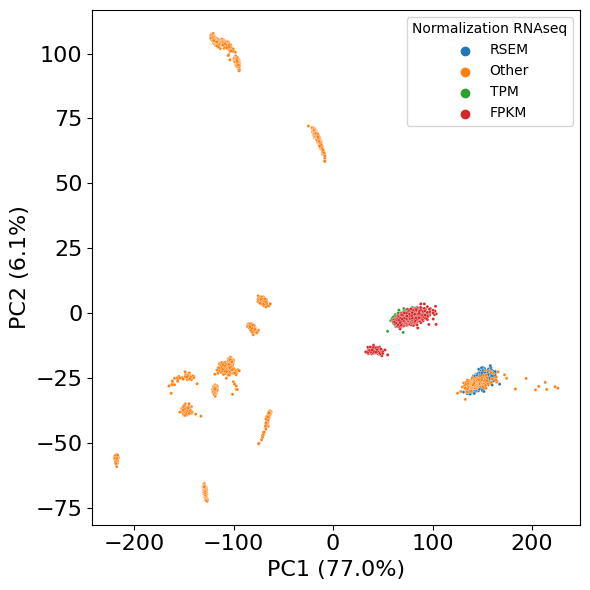

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_meta_df["Sample ID"]
c_df = pd.merge(components_df, final_meta_df, left_index=True, right_on="Sample ID", how="left")

sns.scatterplot(x="PC1", y="PC2", s=5, hue="Normalization RNAseq", data=c_df) # legend=None
plt.xlabel("PC1 (77.0%)", fontsize=16)
plt.ylabel("PC2 (6.1%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(title = "Normalization", prop={'size': 10}, bbox_to_anchor=(0.1, 0.9, 1, 1), loc="right", ncol=1)
plt.savefig(f"{path}/img/breast_normmalization_before_DseepCC1.pdf", format="pdf")
plt.tight_layout()
plt.show()

The problem what was observed is that different method Affymetrix Array, Agilent Array and RNAseq bring technical variability that is higher than variability in subtypes (upper graph). In order to overcome the issue the data will be trandfermed to a functional spectrum, and then used for train_test_split and modeling.

In [ ]:
final_meta_df.groupby("Platform")["Label"].count()

Platform
Affymetrix HG 219 Array       167
Affymetrix HG U133A Array     988
Affymetrix HG133plus2        2524
Agilent Rosetta Array         337
Illumina Array               2086
RNA sequencing               5042
Rosetta/Merck HG2plus2        120
Name: Label, dtype: int64

In [ ]:
final_meta_df.groupby("Dataset")["Label"].count()

Dataset
CPTAC         122
GSE135298      93
GSE20711       88
GSE21653      242
GSE25066      508
GSE45827      130
GSE48390       74
GSE53031      167
GSE56493      120
GSE59595      133
GSE60789       55
GSE65194       98
GSE78958      424
GSE81538      405
GSE96058     3273
METABRIC     1898
NKI           337
ROCK         1468
SMC           168
TCGA          981
TRANSBIG      198
UNT            92
UPP           190
Name: Label, dtype: int64

## Functional spectra conversion

In [ ]:
%load_ext rpy2.ipython
%R install.packages("remote")
%R remotes::install_github("CityUHK-CompBio/DeepCC")
%R library(DeepCC)

In [ ]:
%%script false --no-raise-error 
count = 0
prepr_path = "/home/simonova/Breast_cancer/all_processed"

pipe = make_pipeline(FunctionalSpectra())

final_brca_df = pd.DataFrame()

for f in os.listdir(f"{prepr_path}/"):
  if f.endswith(".tar.gz") and f.startswith("X"):
    count += 1
    geo_name = f.split("_")[1]
    tdf = pd.read_csv(f"{prepr_path}/{f}", index_col=0, compression="gzip")
    tdf = tdf[~tdf.index.duplicated(keep='first')]
    tdf.index.name = ""
    tdf.index = tdf.index.astype("int")
    tdf = tdf.T
    #print(count, geo_name)
    #print(pd.DataFrame(tdf))
    fs = pipe.fit(tdf, _)
    fs.named_steps['functionalspectra'].getLastTransform().to_pickle(f"/home/simonova/Breast_cancer/pickle/{geo_name}.pkl")
    final_brca_df = final_brca_df.append(fs.named_steps['functionalspectra'].getLastTransform())
    print(count, geo_name, "final_brca_df shape", final_brca_df.shape)

#final_brca_df.to_csv(f"{path}/FS/brca_fs_final.csv.zip", compression="zip", index=True) 
#final_meta_df.to_csv(f"{path}/FS/brca_metadata.csv.zip", compression="zip", index=True) 

Called FunctionalSpectra
1 GSE135298.csv.tar.gz final_brca_df shape (93, 22596)


## Data heterogeniety - PCA (functional spectra)

In [ ]:
path = "/home/simonova/Breast_cancer/"

final_meta_df = pd.read_csv(f"{path}/FS/metadata_breast_combined.csv.gz", compression="gzip")
final_meta_df["Platform"] = final_meta_df["Study ID"].map(d_ilmn)
final_meta_df["Normalization"] = final_meta_df["Study ID"].map(d_norm)
final_meta_df["Normalization"] = final_meta_df["Normalization"].str.replace("\t", "")

In [ ]:
final_meta_df.groupby("Normalization")["Sample ID"].count().reset_index()

,Normalization,Sample ID
0,FPKM,3771
1,GC-RMA log2,98
2,Illumina BeadStudio software,55
3,MAS5 normalized,706
4,Partek Genomics Suite software,424
5,REML,130
6,RMA,783
7,RSEM,981
8,RSN,133
9,TPM,122


In [ ]:
final_df = pd.read_csv(f"{path}/FS/brca_fs_final.csv.zip", compression="zip", index_col=0)

In [ ]:
final_df.shape

(11264, 22596)

In [ ]:
final_meta_df.shape

(11264, 5)

In [ ]:
final_df = final_df.reindex(final_meta_df["Sample ID"]) 

In [ ]:
final_meta_df["Technology"] = final_meta_df.apply(RNAseq, axis=1)
final_meta_df["Normalization RNAseq"] =  final_meta_df.apply(NormalizeIt, axis=1)

In [ ]:
comp_dc, labels_dc = scale_pca(final_df)

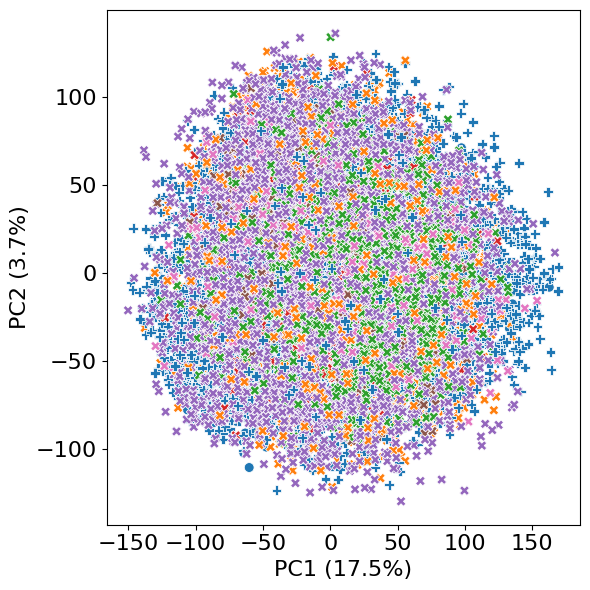

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp_dc)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_meta_df["Sample ID"]
c_df = pd.merge(components_df, final_meta_df, left_index=True, right_on="Sample ID", how="left")

sns.scatterplot(x="PC1", y="PC2", s=50, hue="Platform", style="PAM50", data=c_df, legend=None)
plt.xlabel("PC1 (17.5%)", fontsize=16)
plt.ylabel("PC2 (3.7%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(prop={'size': 10}, bbox_to_anchor=(0.1, 0.9, 1, 1.02), loc="lower right", ncol=2)
plt.tight_layout()
plt.savefig(f"{path}/img/breast_after_DseepCC.pdf", format="pdf")
plt.show()

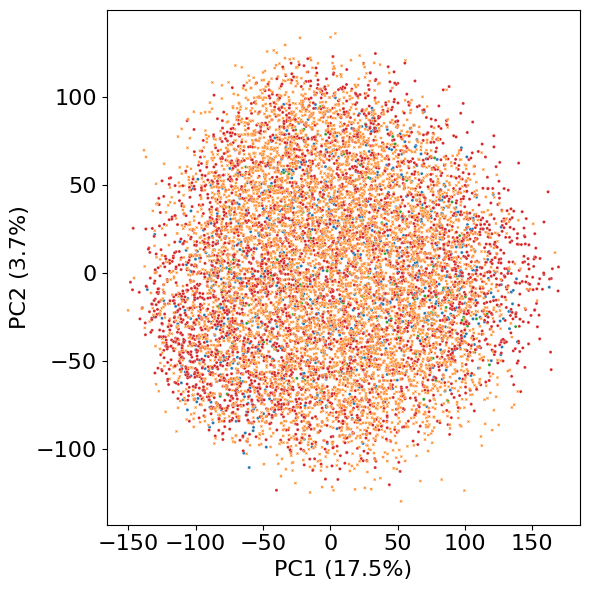

In [ ]:
plt.figure(figsize=(6,6))
components_df = pd.DataFrame(comp_dc)
components_df.columns = [f"PC{i+1}" for i in components_df.columns]
components_df.index = final_meta_df["Sample ID"]
c_df = pd.merge(components_df, final_meta_df, left_index=True, right_on="Sample ID", how="left")

sns.scatterplot(x="PC1", y="PC2", s=5, hue="Normalization RNAseq", style="Technology", data=c_df, legend=None, )
plt.xlabel("PC1 (17.5%)", fontsize=16)
plt.ylabel("PC2 (3.7%)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(prop={'size': 10}, bbox_to_anchor=(0.1, 0.9, 1, 1.02), loc="lower right", ncol=2)
plt.tight_layout()
plt.savefig(f"{path}/img/breast_normmalization_DseepCC.pdf", format="pdf")
plt.show()